# Applied ML

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

In this section we will describe briefly the dataset and give more insight in some details of data collection which might be useful for further exploration and (naive) conclusions.

#### Overview of the dataset

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

*If the real earnings are equal to 0, that means that the person is unemployed*

---

We import `Pandas` to perform basic exploration of the dataset which is conveniently given as a `csv` file. 

In [1]:
import pandas as pd

DATA = 'lalonde.csv'    # path to the file

We load the dataset and show the basic stats of this dataset:

In [2]:
df_lalonde = pd.read_csv(DATA)

df_lalonde.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


Obviously, such general description is not apropriate for all the data columns, but we can extract some general information for this dataset:
- Total number of participants: 614
- There are more control than treatment datapoints (as seen in quartiles)

A more detailed analysis will follow in further analysis. It is significant to mention that the dataset uses two different sources of data for test and control:
- Treatment data (`treat == 1`): **NSW**
- Control data (`treat == 0`): **PSID**

**NSW**: [National Supported Work](http://www.icpsr.umich.edu/icpsrweb/ICPSR/studies/7865) data has been used as a group on which a treatment has been applied. It is somewhat significant to mention which population has such treatment targeted, in order to have more insight in future results (*or misinterpretation of such*):
>National Supported Work Demonstration project, a transitional, subsidized work experience program for four target groups of people with longstanding employment problems: ex-offenders, former drug addicts, women who were long-term recipients of welfare benefits, and school dropouts, many with criminal records. 

We see a very specific group to which such program (treatment) would be possibly beneficial.

**PSID**: [Panel Study of Income Dynamics](https://psidonline.isr.umich.edu/) data has been used as control data, on which the treatment has not been applied. Originally it is a representative sample of families in the USA:
>The study began in 1968 with a nationally representative sample of over 18,000 individuals living in 5,000 families in the United States.

We see a general group to compare the specific group to - to evaluate the results of the program, if such "treatment" improves the performance of the specific group. 

This makes a good baseline for further conclusions based on such data. For an inexperienced person, such data might be less beneficial: it could deepen the bias of wrong conclusion. Sometimes it is better to leave out detailed information not to infer wrong conclusions based on personal bias.

### Task 1 - A naive analysis

---
<div class="alert alert-block alert-info">
<b>Task 1</b>: 
Compare the distribution of the outcome variable (<i>re78</i>) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").
<br>
<br>
What might a naive "researcher" conclude from this superficial analysis?
</div>

---

*Please note that we make deliberate wrong choices, bad practices and harsh conclusions to show possible outcomes of naive analysis.*

In this task we completely forget the postulates of a good research and consider that *correlation == causation*. We are very eager to make a conclusion!

The most important factor to see the success of **National Supported Work Program**, in which significant funds were invested, is whether the population involved has managed to come to the income level of a population which did not parttake in the program. Therefore we will analyze strictly `re78` (income after the program) in correlation with `treat` value (which indicates control or treatment population).

We import our standard libraries to show our results:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from IPython.display import HTML, display

We now select only the data relevant to our desired experiment, the `treat` indicator and corresponding `re78` income data, while ignoring other indicators completely:
- `df_treat_78` indicates the group which has taken part in treatment
- `df_control_78` indicates the control group

In [4]:
df_treat_78 = df_lalonde.loc[df_lalonde['treat']==1].filter(['treat', 're78'])
df_control_78 = df_lalonde.loc[df_lalonde['treat']==0].filter(['treat', 're78'])

We are interested in the basic descriptors of our data, thus we show such stats for both test and control group:

**Treatment group**

In [5]:
df_treat_78.describe()

,treat,re78
count,185.0,185.000000
mean,1.0,6349.143530
std,0.0,7867.402218
min,1.0,0.000000
25%,1.0,485.229800
50%,1.0,4232.309000
75%,1.0,9642.999000
max,1.0,60307.930000


We can conclude following:
- 185 people are in this group
- mean salary is 6349 USD

**Control group**

In [6]:
df_control_78.describe()

,treat,re78
count,429.0,429.000000
mean,0.0,6984.169742
std,0.0,7294.161791
min,0.0,0.000000
25%,0.0,220.181300
50%,0.0,4975.505000
75%,0.0,11688.820000
max,0.0,25564.670000


We conclude:
- 429 people are in the control group
- mean salary is 6984 USD

#### Let us visualize the data

We are very concerned by the data we see in numerical form, let us provide a graphical representation of statistics to have more insight in our data.

We will show a barplot representing the earnings in 1978 (`re78`) depending on the treatment group (`treat`):

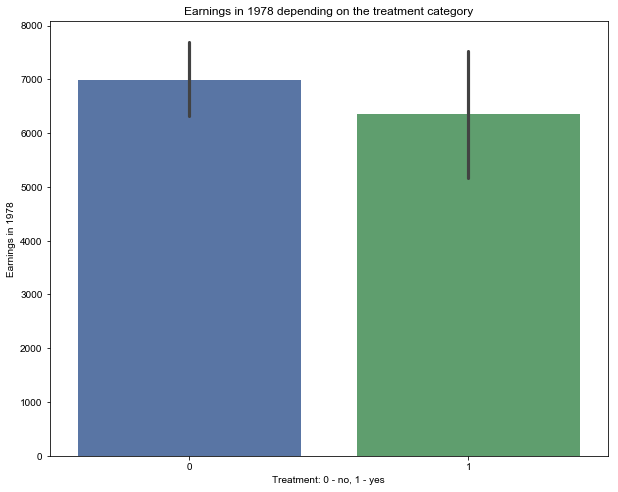

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")

plot_78_bar = sns.barplot(data=df_lalonde, x='treat', y='re78')
plot_78_bar.set_title('Earnings in 1978 depending on the treatment category')
plot_78_bar.set_xlabel('Treatment: 0 - no, 1 - yes')
plot_78_bar.set_ylabel('Earnings in 1978')

We notice the same trend, group who did not take part in the program earns more! 

We could even emphasize and show such difference even better for our viewers to conclude that difference is very significant and that the money has been invested wrongly! (*Once again, naive and wrong on purpose!*)

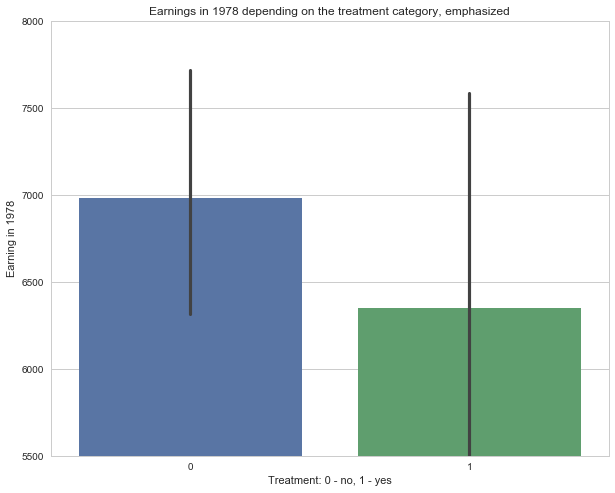

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")
ax.set(ylim=(5500,8000))

plot_78_bar = sns.barplot(data=df_lalonde, x='treat', y='re78')
plot_78_bar.set_title('Earnings in 1978 depending on the treatment category, emphasized')
plot_78_bar.set_xlabel('Treatment: 0 - no, 1 - yes')
plot_78_bar.set_ylabel('Earning in 1978')

To further prove our conclusion, we will perform a simple regression based on our data to see whether our conclusions stand in a more elaborate way.

We would like to see the trend between salary and the treatment or control group (0 and 1). As shown bellow, there is a clear trend displayed that indicates that a higher salary will be achieved without taking part in the program.

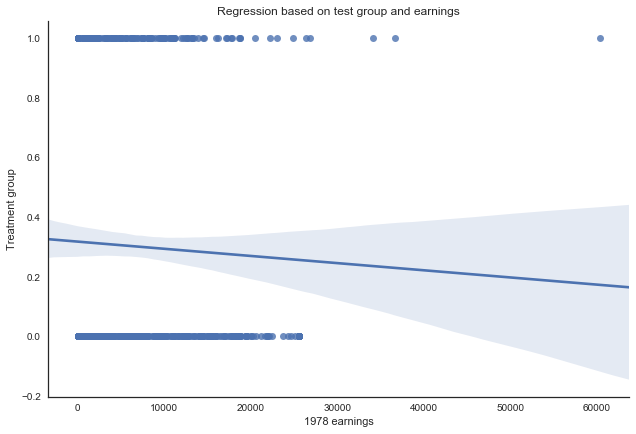

In [9]:
sns.set(style="white")

plot_78_reg = sns.lmplot(data=df_lalonde, y='treat', x='re78', size=6, aspect=1.5)
plot_78_reg.set_xlabels('1978 earnings')
plot_78_reg.set_ylabels('Treatment group')

ax = plt.gca()   # a trick to set a title on lmplot
ax.set_title("Regression based on test group and earnings")

We could as well observe the distribution of the earnings in both control and treatment groups:

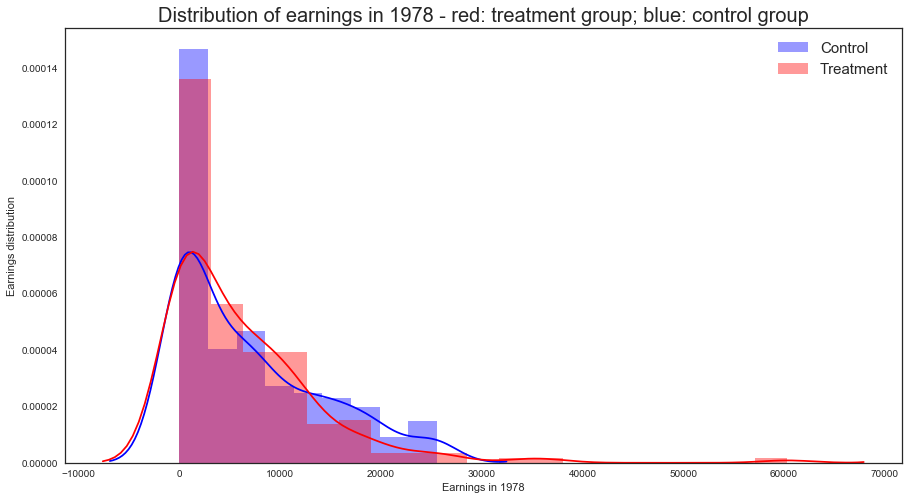

In [10]:
ax, fig = plt.subplots(ncols=1)
ax.set_size_inches(15,8)

plot_78_dist_control = sns.distplot(df_control_78['re78'], color='blue', label='Control')
plot_78_dist_treat = sns.distplot(df_treat_78['re78'], color='red', label='Treatment')

fig.set_title('Distribution of earnings in 1978 - red: treatment group; blue: control group')
fig.set_xlabel('Earnings in 1978')
fig.set_ylabel('Earnings distribution')
fig.title.set_fontsize(20)
fig.legend(prop={'size': 15})

If we observe earnings in both treatment and control group we could observe:
- both have high number of members with earning close to 0. Since that means unemployment, we could conclude that program has affected the overall employability of people involved.
- the distribution of lower earnings is more prominent in the treated group - thus such persons will take a lower payed job
- there are several outliers in the treated group, which we could attribute to statistical probability of such cases appearing

Conversely to the numerical representation and calculation of quartiles: 25%, 50% and 75%, we present the data as box plots along with swarm plots. Here we can observe the concise information provided by the box plots and quartiles, while observing the actual distribution of data points in both groups.

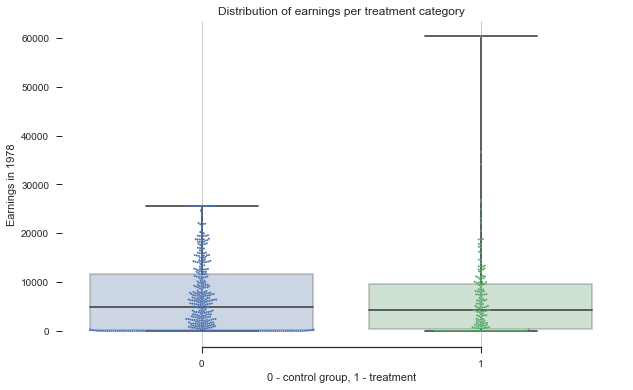

In [11]:
sns.set_style('ticks')

f, ax = plt.subplots(figsize=(10, 6))

# boxplot
ax = sns.boxplot(x='treat', y='re78', data=df_lalonde, whis=np.inf)
plt.setp(ax.artists, alpha=.3)
# swarmplot
plot = sns.swarmplot(x='treat', y='re78', data=df_lalonde, size=2, linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel('Earnings in 1978')
ax.set_xlabel('0 - control group, 1 - treatment')
plot.set_title('Distribution of earnings per treatment category')
sns.despine(trim=True, left=True)

#### A short numerical analysis: The program is a complete failure!

The funds seem to have been completely wasted! The mean income in 1978 for the control group was 6984 USD, while the treated group has only 6349 USD. 

This gives a difference of **635** USD between the groups - and we conclude that a program has failed and did not help treated group to come closer to the control group.

---

As observed in quartiles, the treated group performs worse as well in total:

| group | 25% | 50% | 75% |
|---|---|---|---|
|treated|485|4232|9642|
|control|220|4975|11688|
|control-treated|-265|743|2046|

The treated group has performed better only in the lowest quartile, where the lowest salaries are. In Q2 and Q3 the performance of the treated group is significanlty lower, showing that such population will inherently have predisposition for lower payed jobs in comparison to the general population.

The treatment group has:
- lower mean earnings value
- lower median earnings value
- better first quartile outcomes - in the range of low salaries

---

**Conclusion**: In practical terms we could say that people with criminal records and problematic behavior don't have any hope to reach the level of regular population without such deviant behaviors even with the help of a specialized program. Such populations might have a chance to get only the jobs with the lowest salaries. Thus programs intended for such populations should not be funded since we have proven they do not benefit the population and they are just a hole in the budget.


*Note that blatant conclusions are made on purpose to emphasize what impact could a bad analysis have.*

### Task 2 - A closer look at the data

---
<div class="alert alert-block alert-info">
<b>Task 2</b>: 
You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.
<br><br>
For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.
<br><br>
What do you observe?
<br>
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.
</div>

---

In this task we will look more closely in the per-feature distributions based on the groups which have taken part in the program. 

Instead of observing only the distributions on the final outcome of the National Supported Work Demonstration project (earnings in 1978), we will look more closely into preceding data: earnings in 1974 when the project began, and in 1975 - after the first year of the program. This could prove potentially very significant since we will be given insight if the program has improved the prior state.

We also look into other factors that differ between treatment (project) and control groups given in the dataset such as age or years in education.

For a meaningful analysis and display of distribution we split our values into subsets of *continuous variables* and *categorical variables*.

**Continuous variables**:
- `age`
- `educ`
- `re74`
- `re75`
- `re78`

**Categorical variables**:
- `treat`
- `black`
- `hispan`
- `married`
- `nodegree`

Categorical variables are represented with 0-1, with 0 meaning negative and 1 positive membership. We can notice that `black` and `hispan` are listed. For an easier analysis we can add a column `white`, which is the third category present in the dataset:

In [12]:
df_lalonde['white'] = abs(df_lalonde.black + df_lalonde.hispan - 1)

We have used the fact that `black` and `hispan` are mutually exclusive - they would together add up to value 1 if any is 1. In that case `white` should be 0 - which we achieve by subtracting 1. In case none of `black` or `hispan` is 1, their sum is 0, while `white` should become 1 - which we achieve by taking the absolute value of the previous expression.

Further in this section we will provide:
- a closer overview of continuous variables
- a closer overview of categorical variables

### A closer overview of continuous variables:

The task is to compare distributions of variables in the control and in the treated group. Since the task is practically the same for all of the variables we will write generic functions to reuse for each variable.

In [13]:
'''
A generic function to create a Seaborn distribution plot based on 'treat' value.

Parameters:
dataframe -- dataframe to use
column -- desired column for which to produce the distribution
title -- plot title
size -- plot size
xlabel -- x axis label
ylabel -- y axis label
'''
def create_distplot(dataframe, column, title, size=(15,8), xlabel=None, ylabel=None):
    ax, fig = plt.subplots(ncols=1)
    ax.set_size_inches(size[0], size[1])

    plot1 = sns.distplot(dataframe.loc[dataframe.treat==0][column], label='Control')
    plot2 = sns.distplot(dataframe.loc[dataframe.treat==1][column], label='Treatment')

    fig.set_title(title)
    if(xlabel!=None):
        fig.set_xlabel(xlabel, fontsize=10)
    if(ylabel!=None):
        fig.set_ylabel(ylabel, fontsize=10)
        
    fig.legend(prop={'size': 15})
    fig.title.set_fontsize(20)
    fig.xaxis.label.set_fontsize(15)
    fig.yaxis.label.set_fontsize(15)

'''
A generic function to create a Seaborn barplot based on 'treat' value.

Parameters:
dataframe -- dataframe to use
column -- desired column for which to produce the distribution
title -- plot title
size -- plot size
xlabel -- x axis label
ylabel -- y axis label
'''
def create_barplot(dataframe, column, title, size=(15,8), xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=size)
    sns.set(style="whitegrid")
    
    plot = sns.barplot(data=dataframe, x='treat', y=column)
    
    plot.set_title(title)
    if(xlabel!=None):
        plot.set_xlabel(xlabel, fontsize=10)
    if(ylabel!=None):
        plot.set_ylabel(ylabel, fontsize=10)

    plot.title.set_fontsize(20)
    plot.xaxis.label.set_fontsize(15)
    plot.yaxis.label.set_fontsize(15)

'''
A generic function to create a Seaborn boxplot based on 'treat' value.

Parameters:
dataframe -- dataframe to use
column -- desired column for which to produce the distribution
title -- plot title
size -- plot size
xlabel -- x axis label
ylabel -- y axis label
'''
def create_boxplot(dataframe, column, title, size=(15,8), xlabel=None, ylabel=None):
    sns.set_style('ticks')

    f, ax = plt.subplots(figsize=size)

    # boxplot
    ax = sns.boxplot(x='treat', y=column, data=dataframe, whis=np.inf)
    plt.setp(ax.artists, alpha=.3)
    # swarmplot
    plot = sns.swarmplot(x='treat', y=column, data=dataframe, size=2, linewidth=0)

    # Tweak the visual presentation
    plot.set_title(title)
    plot.title.set_fontsize(20)
    ax.xaxis.grid(True)
    ax.set_ylabel(ylabel)
    ax.xaxis.label.set_fontsize(15)
    ax.yaxis.label.set_fontsize(15)
    ax.set_xlabel(xlabel)
    sns.despine(trim=True, left=True)

In [14]:
'''
A wrapper around generic plot functions.
The result of function invocation are 3 plots on same values, one bellow each other:
- distribution plot
- boxplot
- barplot

Parameters:
dataframe -- dataframe to use
column -- desired column for which to produce the distribution
title -- plot title
size -- plot size
xlabel -- x axis label
ylabel -- y axis label
'''
def create_visual(dataframe, column, title, size=(15,8), xlabel=None, ylabel=None):
    create_distplot(dataframe, column, title, size, xlabel, ylabel)
    create_boxplot(dataframe, column, '', size, xlabel, ylabel)
    create_barplot(dataframe, column, '', size, xlabel, ylabel)

In [15]:
'''
A function for creating an HTML Table out of 2 dictionaries, representing statistical data on treatment and control groups.
Absolute error column (Delta) is added to provide easier interpretation of data.

Parameters:
dict_treat -- dictionary representing statistical data on treatment group
dict_control -- dictionary representing statistical data on control group

Returns:
html - an HTML text describing a table
'''
def make_table(dict_treat, dict_control):
    html = '<table style="margin-left: auto; margin-right: auto;">'
    
    html += "<tr>"
    html += "<th></th><th>Treated group</th><th>Control group</th><th>&Delta;</th>"
    html += "</tr>"
    
    for (k1, v1), (k2,v2) in zip(dict_treat.items(), dict_control.items()):
        html += "<tr>"
        html += "<td>"+k1+"</td><td>"+str(v1)+"</td><td>"+str(v2)+"</td><td>"+str(abs(v1-v2))+"</td>"
        html += "</tr>"
        
    html += "</table>"
    
    return html

'''
A function for displaying basic statistical data about the specified variable.
We display data for both treatment and control groups.

Parameters:
dataframe -- dataframe to use
column -- desired column on which to perform analysis
'''
def show_stats(dataframe, column):
    # we filter the dataframe to obtain only treat and desired column, then select treated group
    treat = df_lalonde.filter(['treat', column]).loc[df_lalonde.treat==1]
    
    # we filter the dataframe to obtain only treat and desired column, then select control group
    control = df_lalonde.filter(['treat', column]).loc[df_lalonde.treat==0]
    
    '''
    We use pandas describe which provides us with quartiles, std, mean, med...
    Then convert the output of describe() from DataFrame to dictionary for easier use,
    and select only the dictionary entry corresponding to the desired column statistics.
    '''
    treat_stats = treat.describe().to_dict()[column]
    control_stats = control.describe().to_dict()[column]
    
    display(HTML(make_table(treat_stats, control_stats))) 

First we will show a distribution plot along with the estimated density, then a box plot superimposed on the swarm plot. Finally we show a standard bar plot. These 3 plots represent the same data, but we have chosen to always display all options since certain features are easier to catch in different types of plots.

### Feature: Age

Age is an important factor when we consider employability. This is especially prominent if the person is unemployed at the moment and seeking a job. Differences in treated and control group in terms of age of the population could bias the results.

In general younger population should have higher prospects of finding a job, while on the other part of the spectrum the chances get lower since employer might seek a more stable, healthy and long term employee.

We can see identical values for the first 2 quartiles, which means that most of the population below the median value in both groups is similar in age. We can see that in the Q3-75% value for the control group is 6 years higher, which indicates there are more older people in the control group.

In [16]:
show_stats(df_lalonde, 'age')

,Treated group,Control group,Δ
min,17.0,16.0,1.0
75%,29.0,35.0,6.0
50%,25.0,25.0,0.0
mean,25.8162162162,28.0303030303,2.21408681409
max,48.0,55.0,7.0
count,185.0,429.0,244.0
std,7.15501927479,10.7866530175,3.63163374268
25%,20.0,19.0,1.0


To assess the previous statements we will show the distribution of age according to the treatment group.

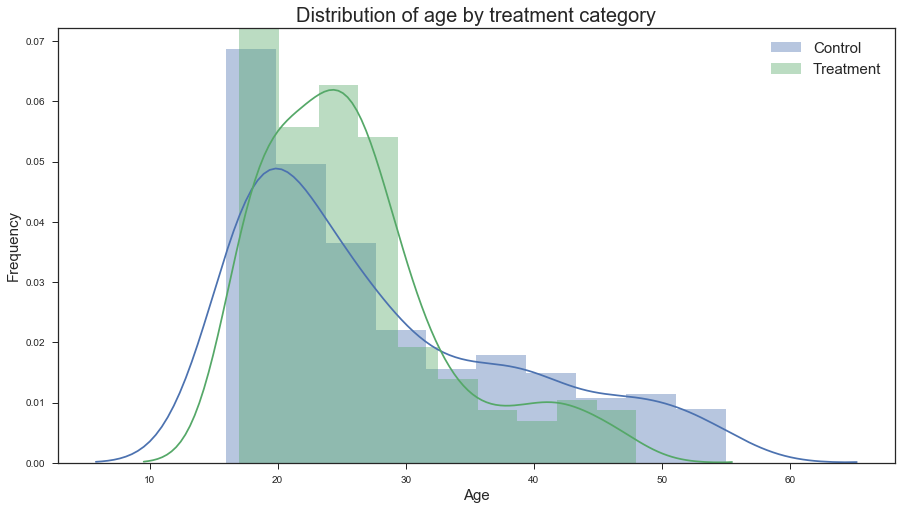

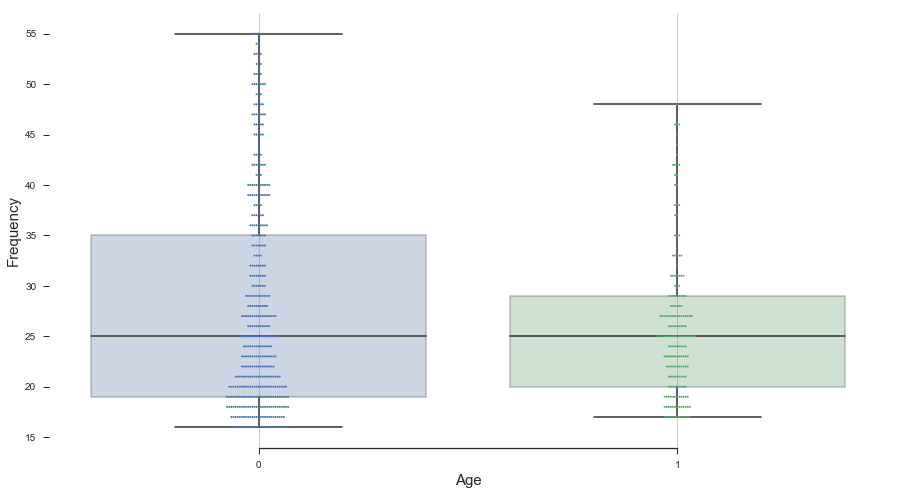

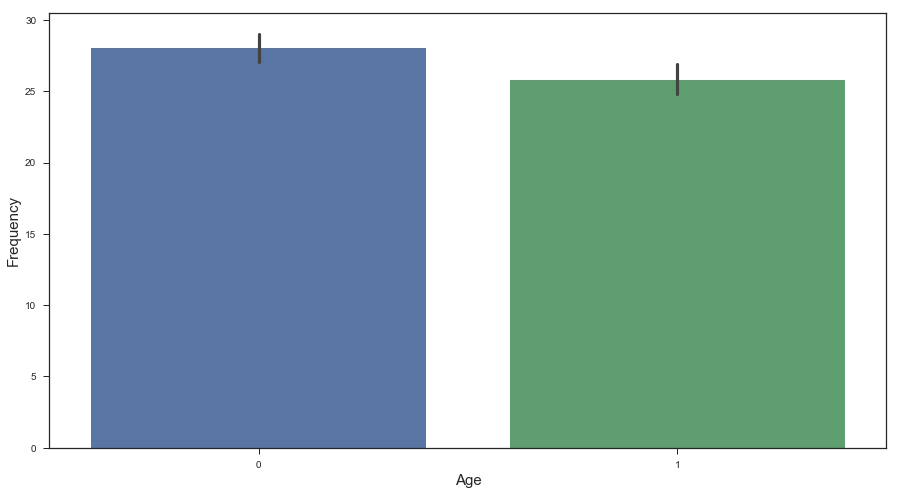

In [17]:
create_visual(df_lalonde, 'age', 'Distribution of age by treatment category', xlabel='Age', ylabel='Frequency')

We can observe that in the treatment group there are generally more younger people than in the control group.

For the treatment group this might make sense - if there was certain admission criteria which preferred such age groups.

**Remark**: Observing age alone, we would say that treatment group should have an advantage in employability and earnings per year.

---

### Feature: Education

Education is an important factor to consider when contemplating employability, but more importantly the earnings in the landed job. The higher the education, or in this case the number of years spent in education, the higher the qualifications should be and thus wider job opportunities and higher payed positions are available.

**Note**: If years spent in education means continuously failing years, but still accruing years, the prior statement is not valid.

We can see a statistical similarity in years spent in education according to the mean, median and quartile values. We will provide deeper insight by showing a graphical representation of distribution of years in education per treatment category.

In [18]:
show_stats(df_lalonde, 'educ')

,Treated group,Control group,Δ
min,4.0,0.0,4.0
75%,12.0,12.0,0.0
50%,11.0,11.0,0.0
mean,10.3459459459,10.2354312354,0.110514710515
max,16.0,18.0,2.0
count,185.0,429.0,244.0
std,2.01065025641,2.85523844088,0.84458818447
25%,9.0,9.0,0.0


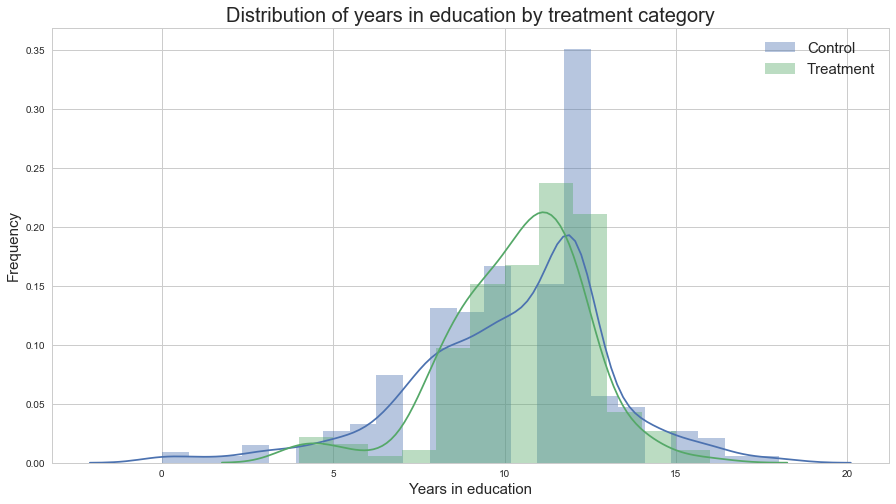

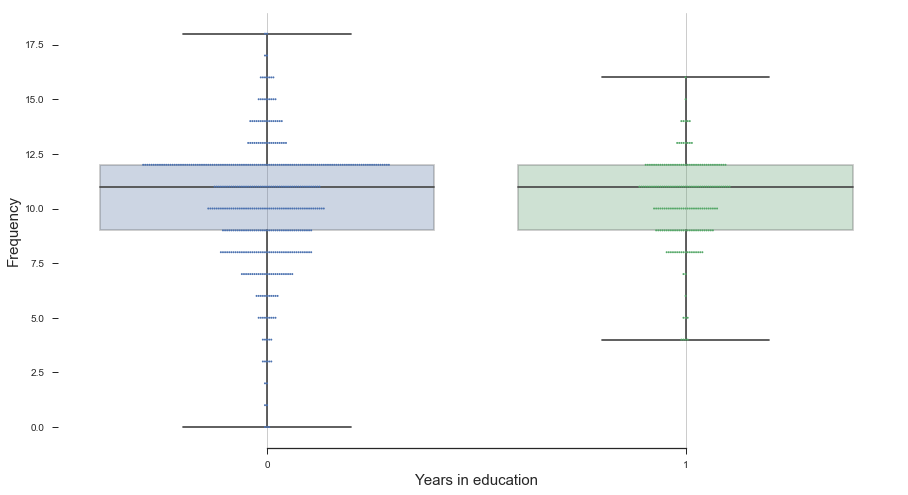

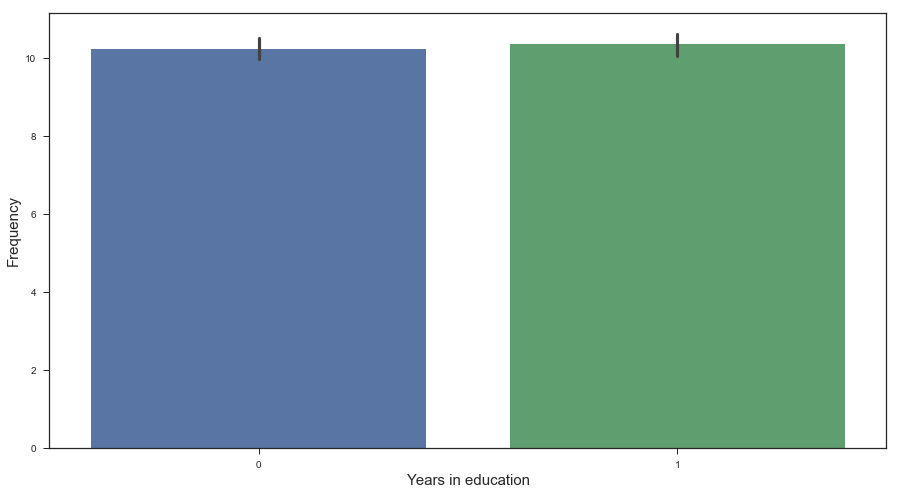

In [19]:
create_visual(df_lalonde, 'educ', 'Distribution of years in education by treatment category', xlabel='Years in education', ylabel='Frequency')

**Remarks**: As we can observe, statistically both groups have similar number of years in education, with mean value for both groups being around 10 years, and median value being 11.

Neither group should have an advantage according to this feature.

---

### Feature: `re74` (Earnings in 1974)

As we have observed before, the NSW program has started in 1974 and targets specific population which has difficulties in finding an employment. 

In accordance with that knowledge, we can conclude that there is a significant gap between treated group and control group, especially when considering mean and median earnings because the treatment populaion has been specifically selected to prefer lower earnings (which are a consequence of unemployment), while the control group is a random sample.

In [20]:
show_stats(df_lalonde, 're74')

,Treated group,Control group,Δ
min,0.0,0.0,0.0
75%,1291.468,9277.128,7985.66
50%,0.0,2547.047,2547.047
mean,2095.57368865,5619.23650639,3523.66281774
max,35040.07,25862.32,9177.75
count,185.0,429.0,244.0
std,4886.62035315,6788.75079646,1902.1304433
25%,0.0,0.0,0.0


We show a visual representation of both control and treatment groups according to the earnings in 1974.

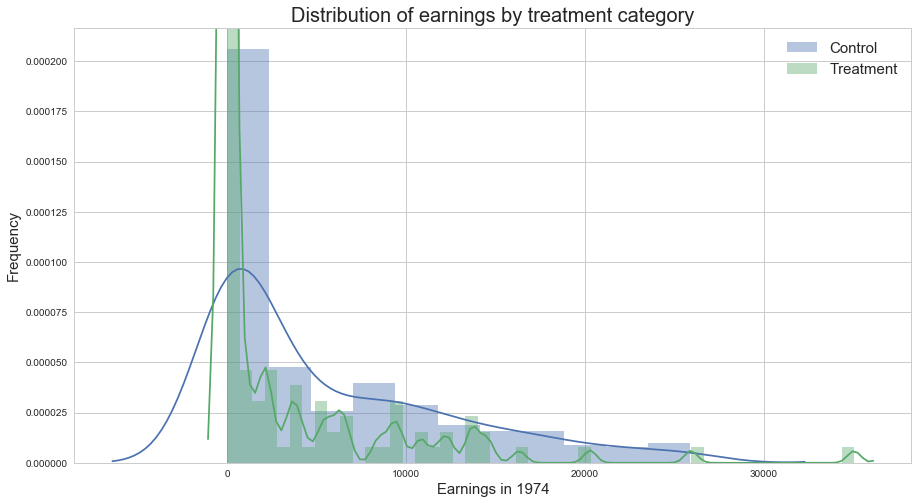

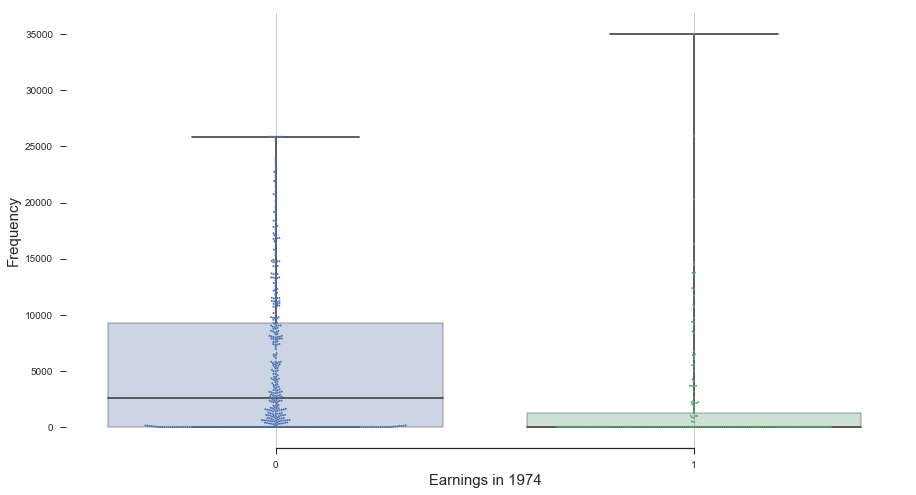

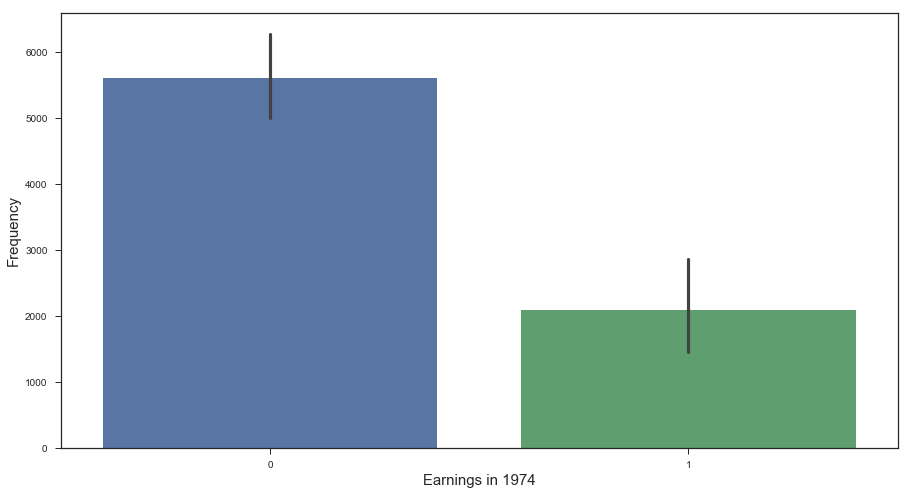

In [21]:
create_visual(df_lalonde, 're74', 'Distribution of earnings by treatment category', xlabel='Earnings in 1974', ylabel='Frequency')

**Remarks**: We can observe that there is a significant number of unemployed persons in the treatment group. This is according to the program setup where we would like to show if the employability program helps such persons to find a job and increase their earnings.

---

### Feature: `re75` (Earnings in 1975)

We observe the earnings in 1975 **only**. We can still observe that treatment groups fares worse than the control group, even after one year of employment program. 

Later on we will observe the earnings accross the years, but let us focus on **1974** and **1975**. We could see a slight improvement when comparing the difference in mean and median earnings in both years.

In [22]:
show_stats(df_lalonde, 're75')

,Treated group,Control group,Δ
min,0.0,0.0,0.0
75%,1817.284,3881.419,2064.135
50%,0.0,1086.726,1086.726
mean,1532.05531378,2466.48444312,934.42912934
max,25142.24,18347.23,6795.01
count,185.0,429.0,244.0
std,3219.25086992,3291.99618331,72.7453133891
25%,0.0,0.0,0.0


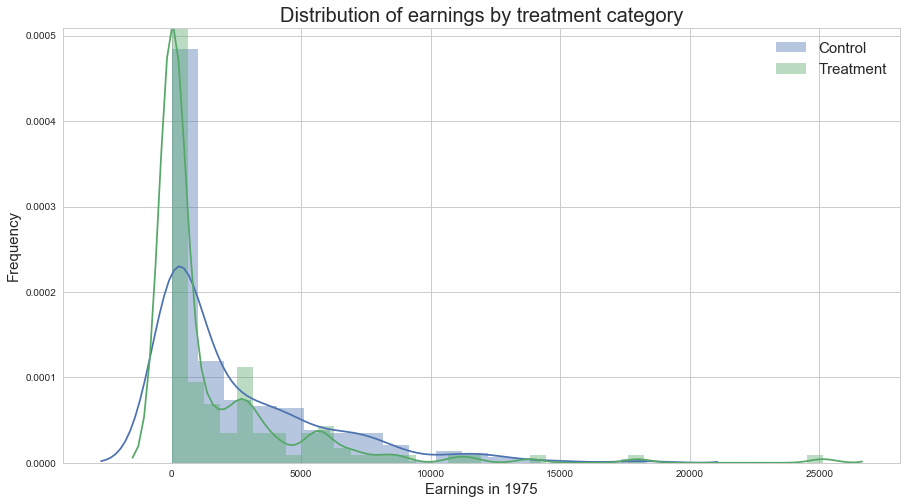

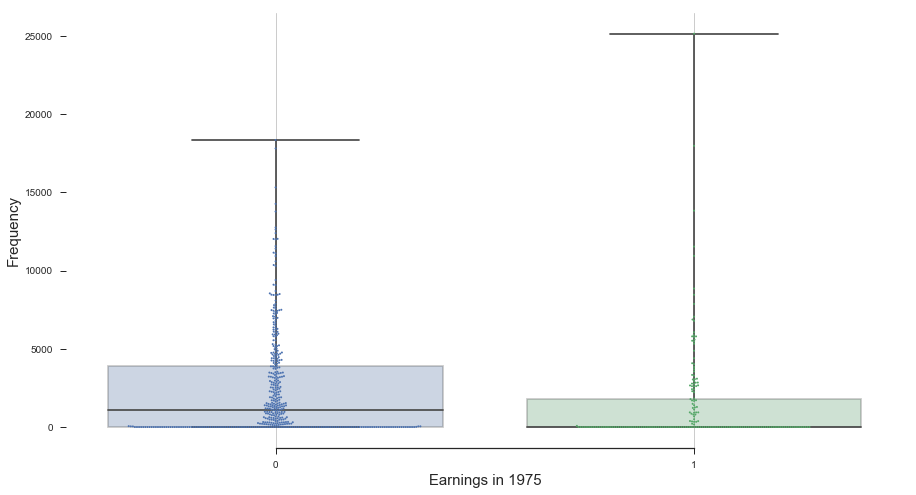

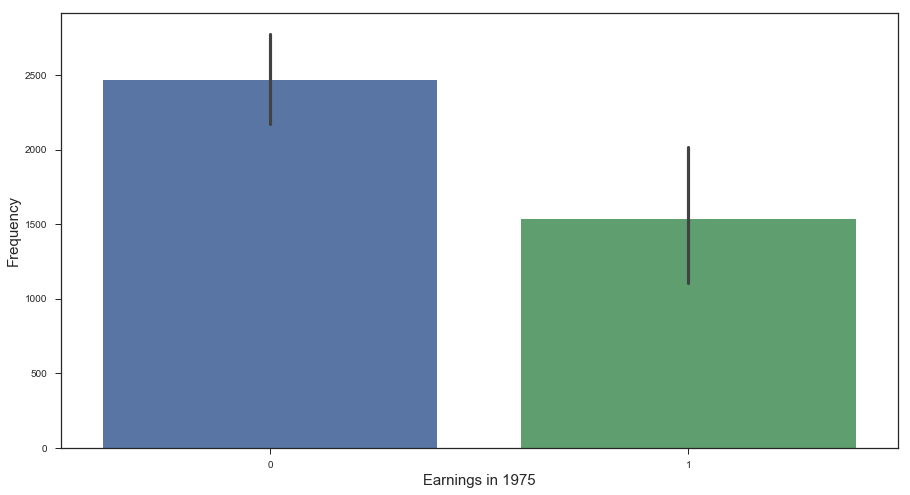

In [23]:
create_visual(df_lalonde, 're75', 'Distribution of earnings by treatment category', xlabel='Earnings in 1975', ylabel='Frequency')

**Remarks**: Comparing with control group, treatment group still fares worse in 1975. Albeit, in comparison to 1974 the gap has become narrower in mean and median earnings, which is a good indicator that the program is giving some positive results.

---

### Feature: `re78` (Earnings in 1978)

As we have previously analyzed, the earnings in 1978 show that median and mean earnings are lower in the treated group than in the control group. On its own we would say this is not a good outcome of the employment program. We certainly need to analyze overal earnings over the years between two groups, which we do after presenting the data for earnings in 1978.

In [24]:
show_stats(df_lalonde, 're78')

,Treated group,Control group,Δ
min,0.0,0.0,0.0
75%,9642.999,11688.82,2045.821
50%,4232.309,4975.505,743.196
mean,6349.14353027,6984.16974231,635.026212037
max,60307.93,25564.67,34743.26
count,185.0,429.0,244.0
std,7867.40221773,7294.16179087,573.240426866
25%,485.2298,220.1813,265.0485


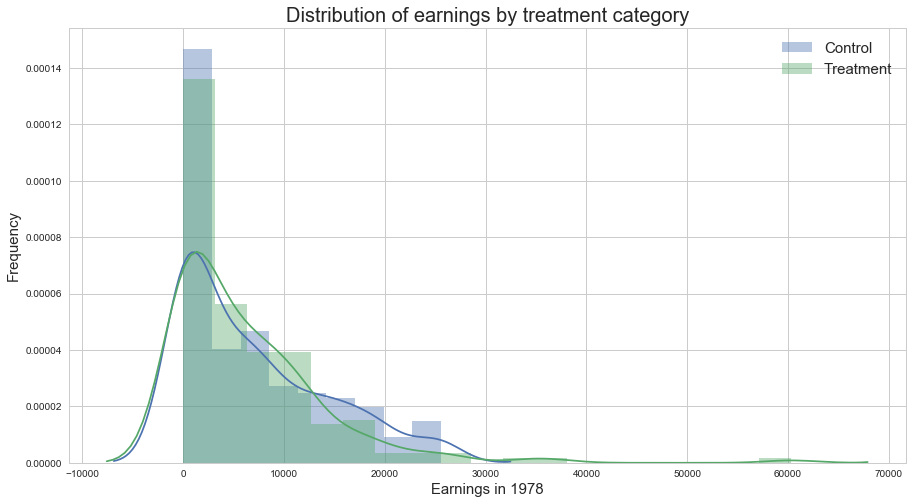

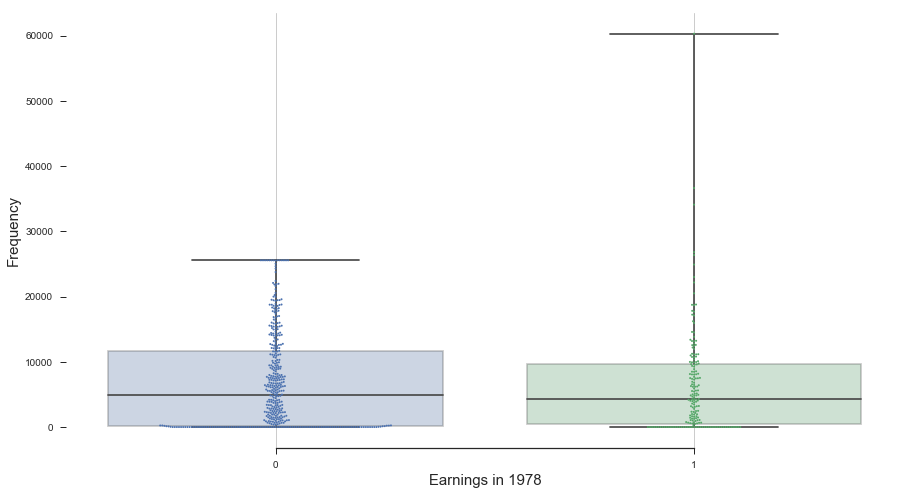

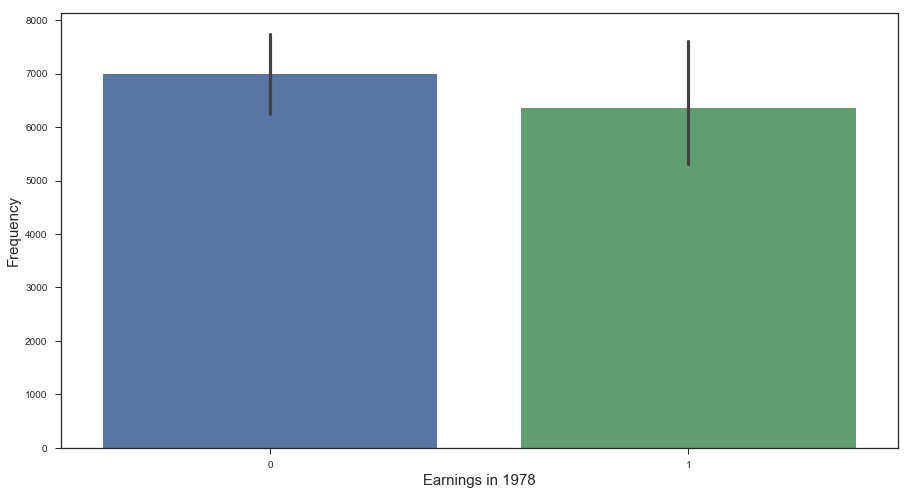

In [25]:
create_visual(df_lalonde, 're78', 'Distribution of earnings by treatment category', xlabel='Earnings in 1978', ylabel='Frequency')

#### Overall earnings remarks

We need to have a closer look into overall earnings, since the beginning of the program in 1974, throught 1975 and then in the end in 1978. We will look into mean and median values over those years. More details are available at graphs and table in each feature analyzed.

<table>
    <tr><th>value</th><th>group</th><th>1974</th><th>1975</th><th>1978</th></tr>
    <tr><td rowspan="3">mean</td><td>control</td><td>5619.23650639</td><td>2466.48444312</td><td>6984.16974231</td></tr>
    <tr><td>treat</td><td>2095.57368865</td><td>1532.05531378</td><td>6349.14353027</td></tr>
    <tr><td>delta</td><td>3523.66281774</td><td>934.42912934</td><td>635.02623961</td></tr>
    <tr><td rowspan="3">median</td><td>control</td><td>2547.047</td><td>1086.726</td><td>4975.505</td></tr>
    <tr><td>treat</td><td>0</td><td>0</td><td>4232.309</td></tr>
    <tr><td>delta</td><td>2547.047</td><td>1086.726</td><td>743.196</td></tr>
</table>

**1974**:
The program targeted categories who have very low probability of getting employed. We can see that in the data from 1974 when the program has commenced. The difference between mean earnings is most prominent between treated and control groups - which is expected since no remedy has yet been applied on treated group.

**1975**:
The program has lasted 1 year and we should be able to see whether there has been any improvement between two groups. The difference between mean earnings has further reduced between the groups.

**1978**:
The program should show its results. We can see that the mean earnings gap has further been reduced in comparison to the previous years. The median has also improved significantly in comparison to the previous years.


The same result can be shown as a chart, further conveying that the gap has been reducing over the years.

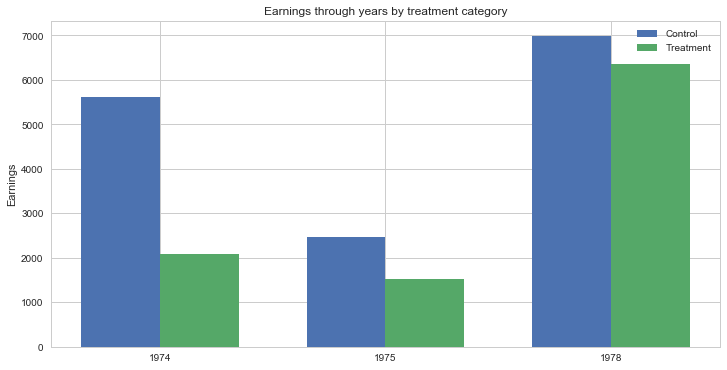

In [26]:
treatment_mean = (5619.23650639, 2466.48444312, 6984.16974231)
control_mean = (2095.57368865, 1532.05531378, 6349.14353027)

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, treatment_mean, width)
rects2 = ax.bar(ind + width, control_mean, width)

ax.set_ylabel('Earnings')
ax.set_title('Earnings through years by treatment category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1974', '1975', '1978'))

ax.legend((rects1[0], rects2[0]), ('Control', 'Treatment'))

plt.show()

**Remark**: After a closer overview of the earnings throughout the years, we can conclude that the program has brought significant benefit to the persons taking part. Overall mean earnings have shifted up in comparison to the control group, while the median earnings have risen as well after several years.

These remarks show that a program was **successful** in some part in contrast to the previous conclusion that the program is a complete **failure**. We still cannot quantify and certainly confirm the success rate, but we can see a more positive outcome of such a program.

We still need to look into the factors of population surveyed and taking part, which are described in *categorical variables*.

---

### A closer overview of categorical variables:

Categorical variables present in this dataset are:
- ethnicity:
    - `black`
    - `hispan`
    - `white` (derived for easier presentation)
- `married`
- `nodegree`

We are interested how are these categories distributed in the treatment and control group. In order to make the comparison reasonable, we calculate the percentage of each category in respective group (treatment or control), since the sample sizes are different (*429* in control and *185* in treatment).

The ratio of categories is extremely important, especially if there is a disbalance between such ratios in control and treatment population. Certain categories might influence the outcome, and disproportion should be accounted for in the final conclusion.

Since we will showcase features several times, we will write a wrapper function for aggregation and display of our categorical data.

In [27]:
'''
A wrapper function for plotting categorical data and returning the aggregated dataframe.

Parameters:
dataframe -- dataframe on which to perform analysis
variables -- desired variables to extract
title -- plot title
x_title -- x axis title
y_title -- y axis title

Returns:
df_grouped_sum -- dataframe with specified categories containing percentage of category in control and treatment
'''
def show_categorical(dataframe, variables, title, x_title='Features', y_title='Percentage', size=(12,7)):
    # we filter out only necessary columns
    df = dataframe.filter(variables)
    
    # we group by treatment - 0 or 1 per column
    df_grouped_sum = df.groupby('treat').sum().reset_index()
    # as we are interested to have the category as value, we transpose the dataframe
    df_grouped_sum = df_grouped_sum.T.reset_index()
    # we no longer need the 'treat' column, that has become a row
    df_grouped_sum.drop(df_grouped_sum.index[0], inplace=True)
    # we rename the obtained columns for easier understanding
    df_grouped_sum.columns=['Category','Control','Treatment']
    
    # we calculate the size of control and treatment groups
    sum_control = dataframe.loc[dataframe.treat==0].shape[0]
    sum_treatment = dataframe.loc[dataframe.treat==1].shape[0]
    
    # we calculate the percentage per treatment category
    df_grouped_sum['Control']=df_grouped_sum['Control']/sum_control*100
    df_grouped_sum['Treatment']=df_grouped_sum['Treatment']/sum_treatment*100
    df_grouped_sum['Delta']=abs(df_grouped_sum['Control']-df_grouped_sum['Treatment'])
    
    
    # we plot a barchart grouped by treatment category
    plot_categorical(df_grouped_sum, title, x_title, y_title, size)
    
    return df_grouped_sum

'''
A helper function to plot categorical variables as grouped barchart.

Parameters:
dataframe -- dataframe to plot
title -- plot title
x_title -- x axis title
y_title -- y axis title
'''
def plot_categorical(dataframe, title, x_title, y_title, size):
    plot = dataframe.plot.bar(y=['Control','Treatment'], x=['Category'], figsize=size, fontsize=15)
    plot.set_title(title)
    plot.set_xlabel(x_title)
    plot.set_ylabel(y_title)
    plot.legend(prop={'size': 12})
        
    plot.title.set_fontsize(20)
    plot.xaxis.label.set_fontsize(15)
    plot.yaxis.label.set_fontsize(15)
    

### Ethnicity

Three ethnicities have taken part in the study, and we would like to have a closer look on the distribution of three in both categories.

We show a dataframe which represents the percentage of each category per control and treatment sets, respectively. This analysis per category was a reasonable choice for us, since the sample size is not the same for control and treatment groups.

,Category,Control,Treatment,Delta
1,black,20.279720,84.324324,64.044604
2,hispan,14.219114,5.945946,8.273168
3,white,65.501166,9.729730,55.771436


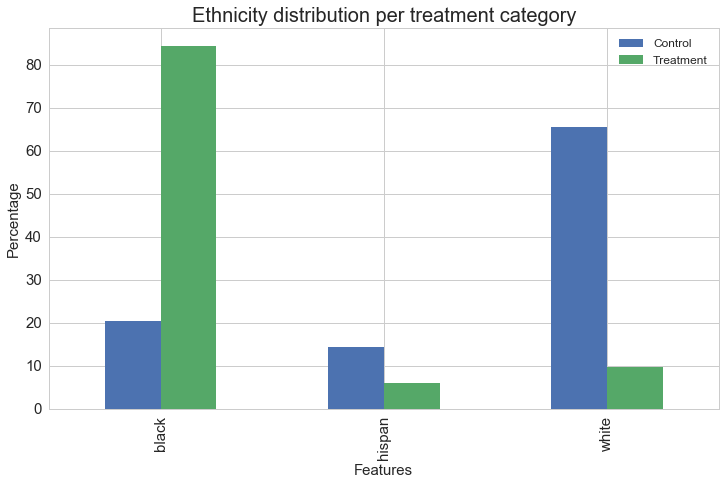

In [28]:
show_categorical(df_lalonde, ['treat','black','hispan','white'],'Ethnicity distribution per treatment category')

We can notice the disproportion in population based on ethnicity:
- **control sample**: approx. 20% black, 14% hispanic and 66% white people
- **treatment sample**: approx. 84% black, 6% hispanic and 10% white people

The differences are more prominently visible in graphical representation. We see that the population sample based on ethnicity is skewed.

**Remarks**: In general there are more white people in the control sample, and more black people in the treatment sample. Taking into consideration the sentiment at the time of the employment program in the USA towards people with past criminal record or substance abuse, especially towards people of color, we could conclude that results might be less favorable for the treatment group.

The earnings of treatment group are expected to be less than those in the control group.

### Marital status and education

Marital status and education could play a significant role in the overall employability, job stability and most importantly impact the yearly earnings.

,Category,Control,Treatment,Delta
1,nodegree,59.673660,70.810811,11.137151
2,married,51.282051,18.918919,32.363132


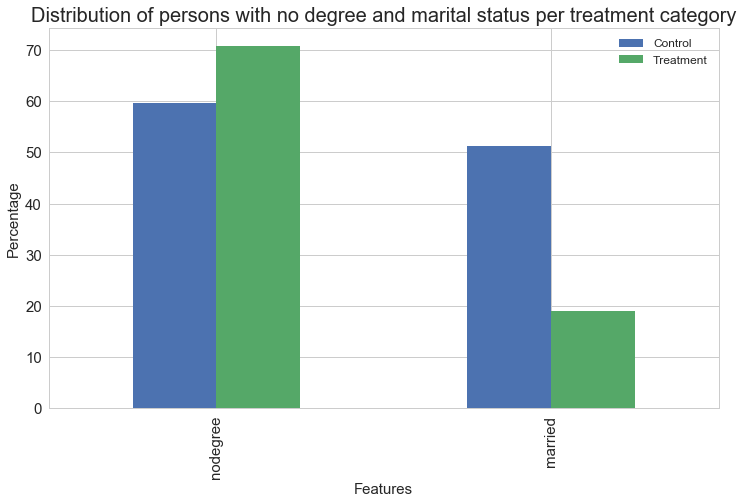

In [29]:
show_categorical(df_lalonde, ['treat','nodegree', 'married'],'Distribution of persons with no degree and marital status per treatment category')

**Remarks**:
There is a difference of 11.13% in persons who did not obtain a degree between control and treatment group. This is a significant difference, yet, one of the categories which has a lower delta in comparison to other categorical variables. Persons with a degree usually have a higher chance of landing a job with higher earnings.

Marital status shows a higher difference which might give insight in either:
- age of participants (too young for marriage)
- life instability (criminal activities, substance abuse)
We could possibly conclude that there is a discrepancy in control and treatment groups for those reasons, which subsequently impact long term employability and progression in job towards higher payed positions.

The overall earnings for the treatment group are expected to be lower than those in the control group.

### Task 3 - A propensity score model
---

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```
<div class="alert alert-block alert-info">
Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)
</div>

In [30]:
from sklearn import linear_model, metrics
logistic_classifier = linear_model.LogisticRegression(penalty='l1')

dataset = pd.read_csv(DATA, index_col='id')

As presented in the amazing [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/) of Peter Austin and also in the course 5 - [Observational Studies](https://docs.google.com/presentation/d/1ndR2nCaFVtbryfbwSZUrFBIowy5_Gj8ETcrdz4euCXE/edit#slide=id.g25d09776e5_0_114), we need to compute propensity scores when we are dealing with observational studies. This is because the data available is usually misleading if it is not processed in this sense, as it might be easily observed in this dataset's case, where we have features for which the distribution in the treated and the control group are *very* different. Therefore, we cannot say for sure if the impact on the earnings is due to the treatment or to the difference in distribution of the features. 

The technique in this case would be to calculate the propensity scores. As stated by Austin, the instances with similar propensity scores have the same distribution over the input features. After computing the propesity scores, we must match instances with similar propensity scores and then reconstruct the dataset only with the matched instances. In this way, the distribution for each feature is very similar under the treatment and control group, so it can be considered that the seen changes in the result are due to the treatment. 

In [31]:
feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75'] 
# notice that 're78' is not included, because it is collected AFTER the treatment, therefore cannot influence the decision of 
# being treated or not.

X_train = dataset[feature_cols]
y_train = dataset.treat

logistic_classifier.fit(X_train, y_train)
propensity_scores = pd.Series(logistic_classifier.predict_proba(X_train)[:,1], name='score', index=dataset.index)
# propensity score for each datapoint, represented by the probability of being treated based on all pre-treatment features

In [32]:
propensity_scores.head()

id
NSW1    0.579679
NSW2    0.199804
NSW3    0.686527
NSW4    0.734067
NSW5    0.694213
Name: score, dtype: float64

### Task 4 - Balancing the dataset via matching

<div class="alert alert-block alert-info">
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the <i>networkx</i> package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?
</div>

In this exercise, we want to construct a new dataset which, for each feature, has similar distributions on both control and treatment groups. This being the current goal, we can use any of the methods presented by *Peter Austin*: 
- propensity score matching
- stratification on the propensity score
- inverse probability of treatment weighting using the propensity score
- covariate adjustment using the propensity score.

First, we want to add the propensity score as a new feature for each instance in the dataset, and then split the dataset into two subsets that form a partition: the *control* dataset and the *treatment* dataset:

In [33]:
dataset['propensity_score'] = propensity_scores

treatment = dataset[dataset.treat == 1]
control = dataset[dataset.treat == 0]

#### Defining similarity function between instances

We are using the propensity score matching method, and will choose not for a greedy algorithm, but for a minimum bipartite matching. For this, we need to construct a graph, where each node is represented by a different instance in the dataset. Furthermore, we will construct a bipartite graph, where the two partitions are represented by the nodes in the *control* group and the *treatment* group. This is realized by linking any two nodes that correspond to instances from different groups, and the edge weight will be equal to the absolute value of the difference of the propensity score between the two nodes, as presented in [Course 5](https://docs.google.com/presentation/d/1ndR2nCaFVtbryfbwSZUrFBIowy5_Gj8ETcrdz4euCXE/edit#slide=id.g25d09776e5_0_114).

First, we need to define a similarity function between two instances. This will be represented as the inverse of the absolute value of the difference of propensity scores of the two instances, $sim = 1 - \vert propensity(u) - propensity(v)|$, where $u, v$ define the two instances. The first idea would be to consider $sim =  |propensity(u) - propensity(v)|$, but then we will have $sim \leq 0,$ for any two instances. We can easily see that, because the propensity score is in fact defined by a probability, then it has values between 0 and 1, therefore the value $ |propensity(u) - propensity(v)| \in [0, 1]$. Therefore, we have  $1 - \vert propensity(u) - propensity(v)| \in [0,1]$, and the similarity function increases as the two propensity scores get closer to each other. The similarity function is implemented below:

In [34]:
def compute_similarity_between_nodes(row_1, row_2):
    '''
    Function that computes the similarity between two instances based on the inverse (in the additive group (Z, +)) of the 
    absolute value of the difference of propensity scores of the two instances. 
    
    :param row_1: the information of the first instance, which is encoded as a row of the dataset DataFrame
    :param row_1: the information of the first instance, which is encoded as a row of the dataset DataFrame
    
    :return: the similarity between the two instances, expressed as a number between 0 and 1. Note: the nodes will have a bigger 
    similarity as they have a closer propensity score.
    '''
    
    return 1-abs(row_1['propensity_score'] - row_2['propensity_score'])

#### Constructing the bipartite graph for matching

For constructing the graph and realizing the matching, we will use the **networkx** package, as indicated in the statement:

In [35]:
from networkx import *

First, we define a function that constructs the bipartite graph as indicated above, linking every node from the instance group with a node from the treatment group, and every edge having as weight the similarity score between the two nodes:

In [36]:
def construct_bipartite_graph(treatment_group, control_group):
    '''
    Function that computes the bipartite graph, given the two groups: treatment and control.
    
    :param treatment_group: the instances in the treatment group, as a subset of the dataset DataFrame
    :param control_group: the instances in the control group, as a subset of the dataset DataFrame
    
    :return: the bipartite undirected graph in which only instances from different groups are connected, and the weight of each
    edge is equal to the similarity between the two instances represented by the two nodes.     
    '''

    bipartite_graph = Graph() # constructing the undirected graph

    # Then, we need to create the edge between ALL the nodes from different groups:
    for id_treatment, row_treatment in treatment_group.iterrows():
        for id_control, row_control in control_group.iterrows():
            
            similarity = compute_similarity_between_nodes(row_treatment, row_control)
            # similarity between the two instances
            bipartite_graph.add_weighted_edges_from([(id_treatment, id_control, similarity)]) 
            # add the new edge. If nodes don't exist, then method also creates nodes and adds them to the graph.
            # the similarity is added as the attribute 'weight' such that we can apply the matching algorithm afterwards
            
    return bipartite_graph

#### Defining the matching function

Next, we want to define the function that will compute the list of matched instances. We want to make it general, therefore adding the function that creates the bipartite graph as parameter (which will be next used at *Task 5*):

In [37]:
def compute_maximum_similarity_matching(treatment_group, control_group, compute_graph_function, threshold=None):
    '''
    Function that computes the propensity score matching on the control group and the treatment group
    
    :param treatment_group: the instances in the treatment group, as a subset of the dataset DataFrame
    :param control_group: the instances in the control group, as a subset of the dataset DataFrame
    :param compute_graph_function: the function that computes the bipartite graph needed for matching
    :param threshold: parameter which specifies the threshold for similarity. If similarity is below threshold, then don't 
    pair the instances
    
    :return: the propensity score matching, as a list of pairs [(treatment_instance, control_instance)]
    '''
    bipartite_graph = compute_graph_function(treatment_group, control_group)
    match_dictionary = max_weight_matching(bipartite_graph)
    # the dictionary holds redundant information, i.e. if it holds the pair (u, v), then holds also the pair (v, u)
    
    treatment_ids = set(treatment_group.index)
    control_ids = set(control_group.index)
    
    result = [] # the result list of matched instances
    
    for u, v in match_dictionary.items():
        if u in treatment_ids:
            similarity = 1 - abs(treatment_group.loc[u, 'propensity_score'] - control_group.loc[v, 'propensity_score'])
            if threshold is None or similarity >= threshold:
                result.append((u, v))
    
    return result

#### Applying matching function to dataset

After writing the function necessary for computing the similarity matching, we need to apply it to our dataset:

In [38]:
similarity_matching = compute_maximum_similarity_matching(treatment, control, construct_bipartite_graph)

Now, we need to reconstruct the paired treatment and control datasets:

In [39]:
treatment_paired_ids = [pair[0] for pair in similarity_matching] # the IDs of the treatment paired instances 
control_paired_ids = [pair[1] for pair in similarity_matching] # the IDs of the control paired instances

treatment_paired = dataset[dataset.index.isin(treatment_paired_ids)] # the dataset of the treatment paired instances
control_paired = dataset[dataset.index.isin(control_paired_ids)] # the dataset of the control paired instances

#### Reanalysis of the results

After constructing the new treatment and control groups, we would like to perform the same analysis as for the first and second task. Therefore, we can look first at the mean of the earnings in 1978 (after treatment), in both control and treatment group: 

In [40]:
control_paired.re78.mean(), treatment_paired.re78.mean()

(5739.1544856756746, 6349.1435302702712)

Next, we can define a generic function for plotting the results, which would help us better understand the data:

In [43]:
def plot_distribution_variable(treatment_group, control_group, feature, params):
    control_delta = control_group[feature].max() - control_group[feature].min()
    treatment_delta = treatment_group[feature].max() - treatment_group[feature].min()

    if treatment_delta > control_delta:
        hist_range = (treatment_group[feature].min(), treatment_group[feature].max())
    else:
        hist_range = (control_group[feature].min(), control_group[feature].max())

    # Previous lines of code is necessary for preserving the same bins range for both histograms.\n",


    control_group[feature].plot.hist(bins=30, range=hist_range, grid=True, alpha=0.5, label='control', color='green', **params)
    treatment_group[feature].plot.hist(bins=30, range=hist_range, grid=True, alpha=0.5, label='treatment', color='blue', **params)

    plt.legend(loc='upper right')

It can be seen that, with the constructed control and treatment groups, the mean of the earnings of the participants in the treatment group is larger than the mean of earnings of participants in the control grop, with \$647. Also, the differences in earnings between control and treatment group could be spotted visually in the next histogram:

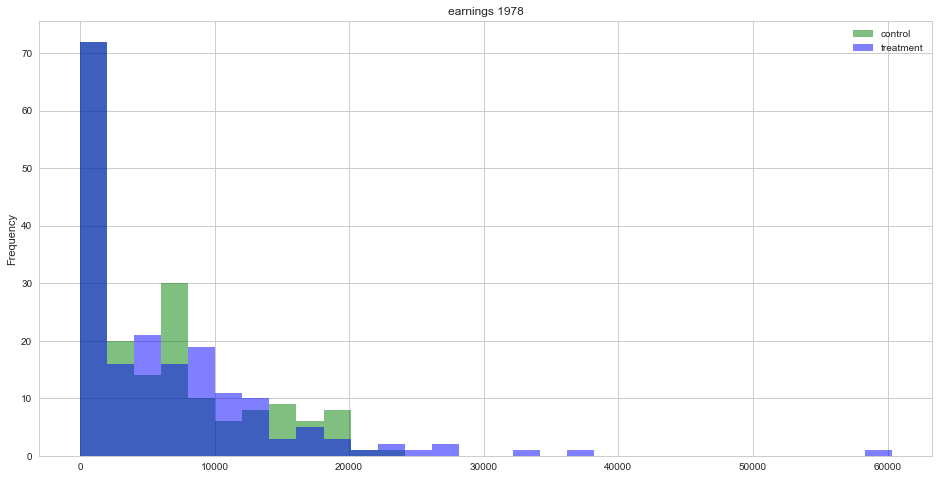

In [44]:
plot_distribution_variable(treatment_paired, control_paired, 're78', {'title': 'earnings 1978', 'figsize':(16, 8)})

We want to verify, though, if the propensity score matching did the job intended, i.e. for each feature in the dataset, its distribution in the treated group is similar to the distribution in the control group. For this, we will plot the distribution for all the features in both groups, below:

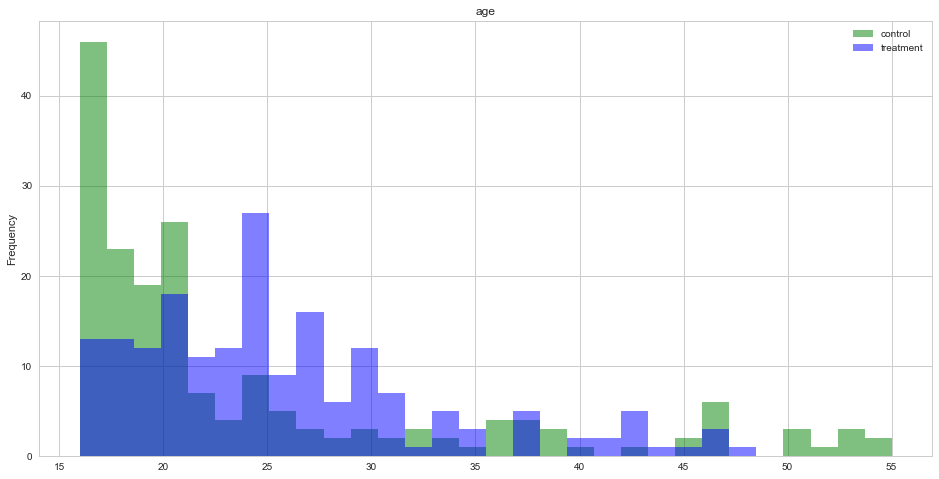

In [45]:
plot_distribution_variable(treatment_paired, control_paired, 'age', {'title' : 'age', 'figsize':(16,8)})

The *age* variable seems to have a different distribution in treatment and control groups.

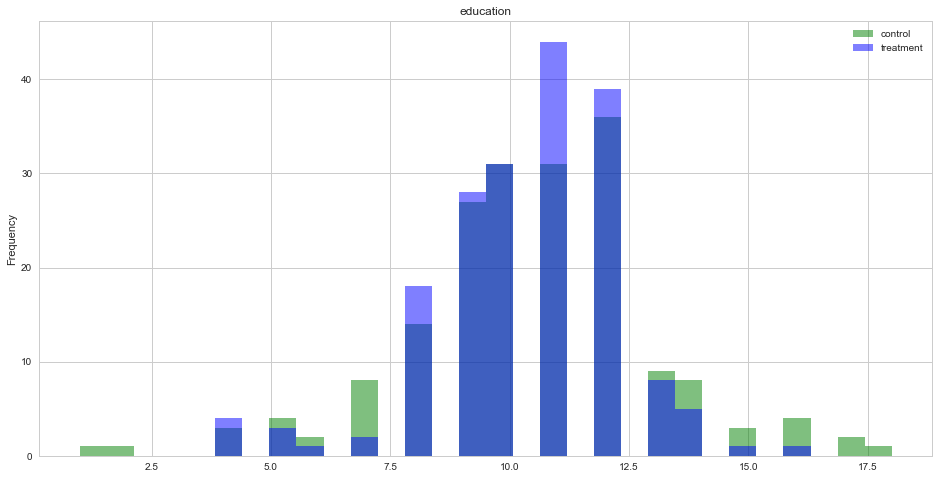

In [46]:
plot_distribution_variable(treatment_paired, control_paired, 'educ', {'title' : 'education', 'figsize':(16,8)})

The *educ* variable seems to have similar distribution in treatment and control groups.

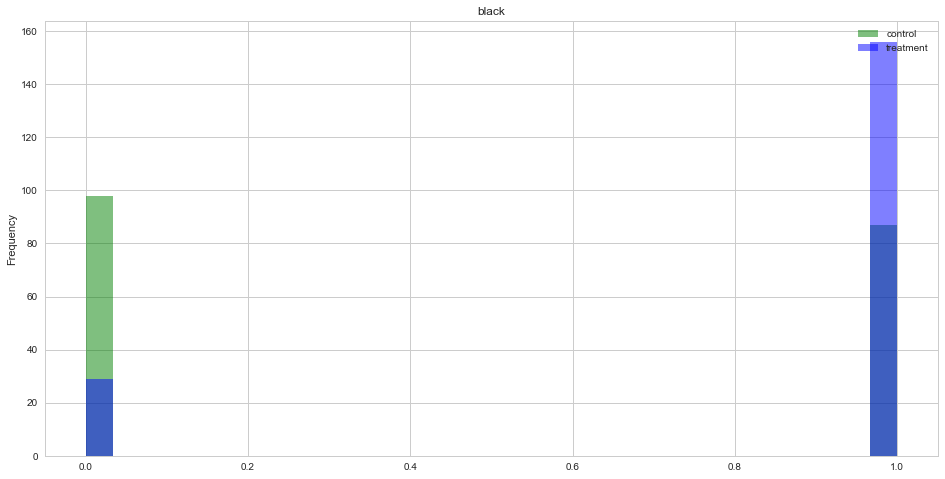

In [47]:
plot_distribution_variable(treatment_paired, control_paired, 'black', {'title' : 'black', 'figsize':(16,8)})

The *black* variable seems to have different distributions in treatment and control groups.

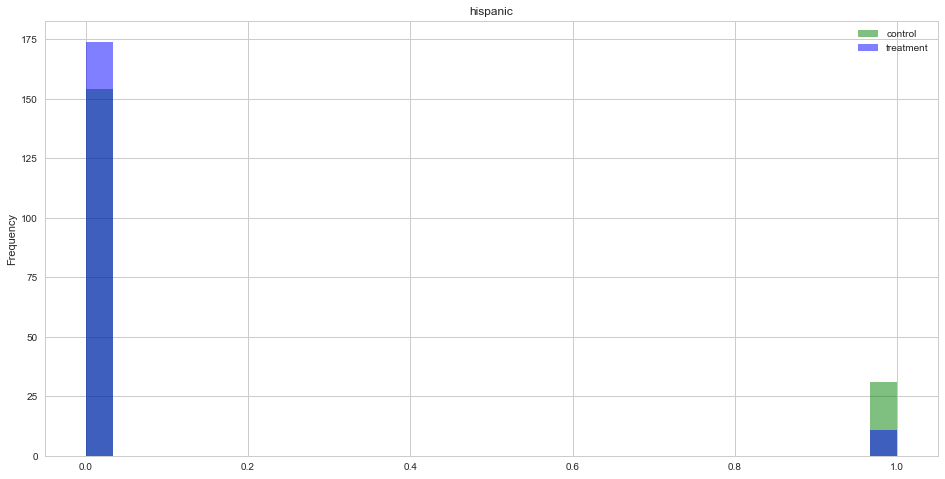

In [48]:
plot_distribution_variable(treatment_paired, control_paired, 'hispan', {'title' : 'hispanic', 'figsize':(16,8)})

The *hispan* feature seems to have somewhat similar distributions in treatment and control groups.

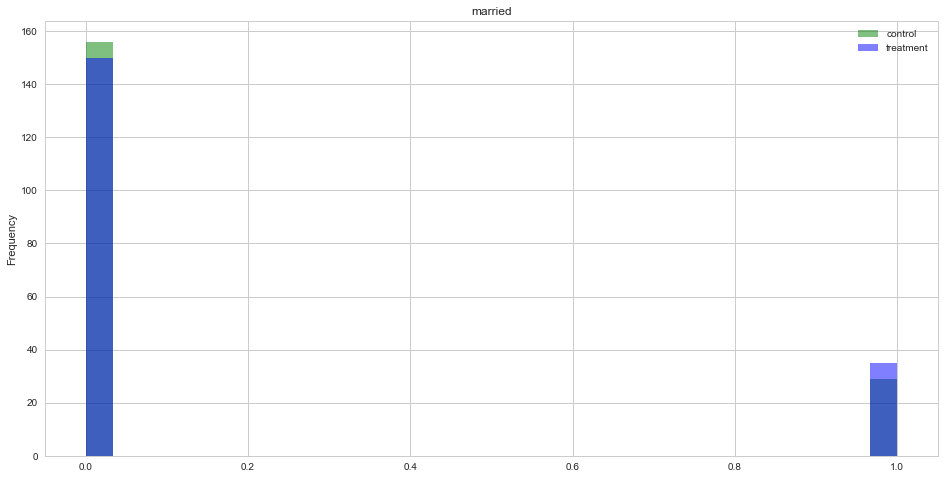

In [49]:
plot_distribution_variable(treatment_paired, control_paired, 'married', {'title' : 'married', 'figsize':(16,8)})

Also, the *married* variable seems to have similar distribution in both groups.

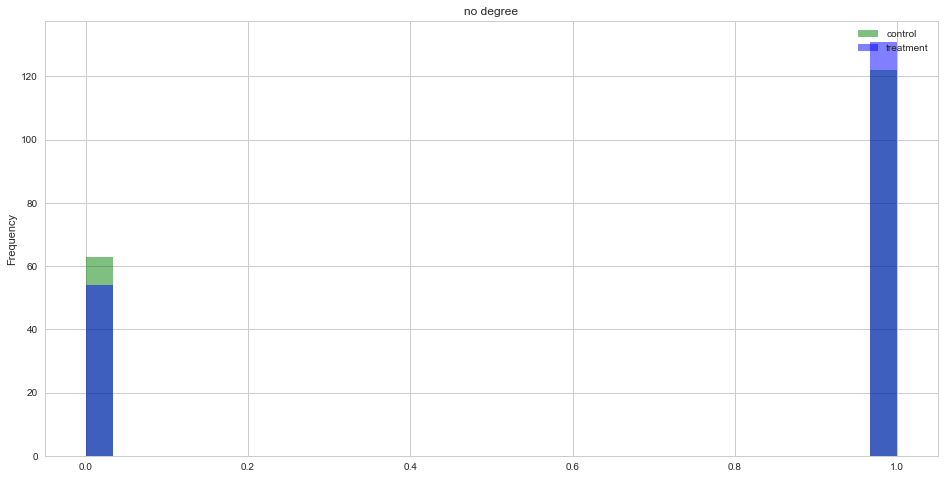

In [50]:
plot_distribution_variable(treatment_paired, control_paired, 'nodegree', {'title' : 'no degree', 'figsize':(16,8)})

Furthermore, *nodegree* feature distribution over the two groups seems to be similar.

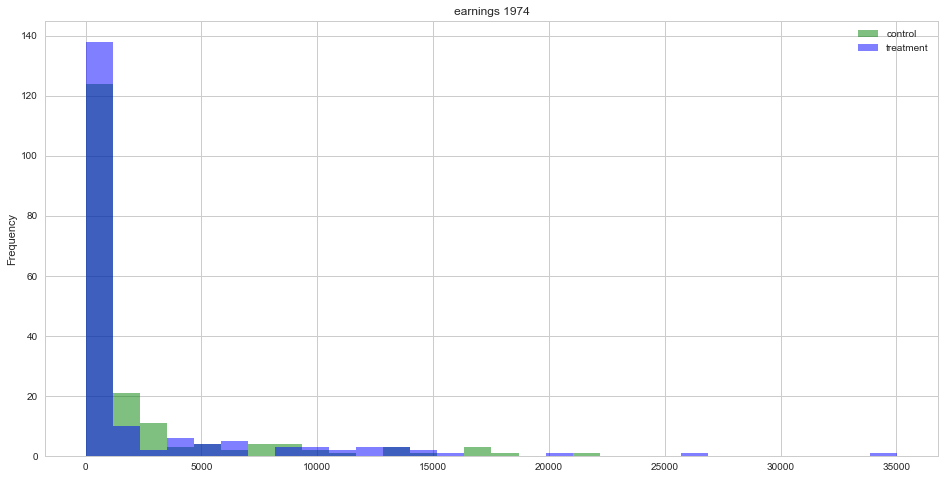

In [51]:
plot_distribution_variable(treatment_paired, control_paired, 're74', {'title' : 'earnings 1974', 'figsize':(16,8)})

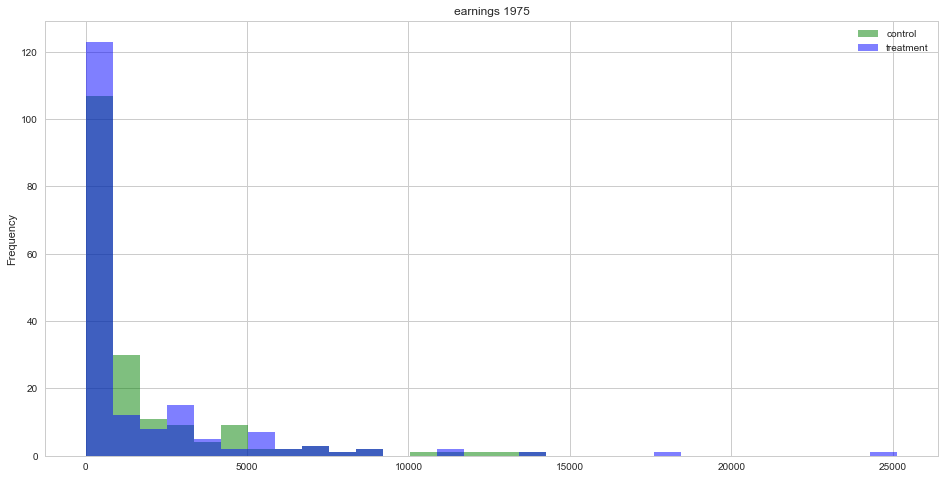

In [52]:
plot_distribution_variable(treatment_paired, control_paired, 're75', {'title' : 'earnings 1975', 'figsize':(16,8)})

Also, earnings in both years 1974 and 1975 have a somewhat similar distribution in both treatment and control groups.

Therefore, we observe that only the *black* and *age* features have different distributions after the matching in the two groups, and the other ones have similar distributions, which means that the two groups considered now are more reliable than the initial ones, from this point of view.

### Task 5 - Balancing the groups further 

<div class="alert alert-block alert-info">
Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.
</div>

#### General idea

We just mentioned that the *black* and *age* features have very different distributions in the two groups. We may want to manually solve this problem, tuning the matching function. We can see that the age has many possible values, so matching only persons with very similar ages is hard to implement. In the same time, the *black* variable has only two possible values: 0 and 1, which means that matching only people with the same feature on the *black* variable might give an extra boost to the results. Indeed, as we may now, black people represent by itself a sensitive group when we talk about employment, therefore this particular feature should have a lot of impact in interpreting the results. 

Therefore, we might only change the function that constructs the bipartite graph on which is therefore computed the maximal weighted match. In order to only match instances with the same value on feature *black*, we will only add an edge between the wanted instances, and then all the process will follow as before.

#### Construction of the mentioned bipartite graph

The new function for constructing the graph, as mentioned in the previous cell, is written below:

In [54]:
def construct_bipartite_graph_same_race(treatment_group, control_group):
    '''
    Function that computes the bipartite graph, given the two groups: treatment and control, but not adding edges between
    instances with different value on feature black.
    
    :param treatment_group: the instances in the treatment group, as a subset of the dataset DataFrame
    :param control_group: the instances in the control group, as a subset of the dataset DataFrame
    
    :return: the bipartite undirected graph in which only instances from different groups are connected, and the weight of each
    edge is equal to the similarity between the two instances represented by the two nodes.     
    '''

    bipartite_graph = Graph() # constructing the undirected graph

    # Then, we need to create the edge between ALL the nodes from different groups:
    for id_treatment, row_treatment in treatment_group.iterrows():
        for id_control, row_control in control_group.iterrows():
            if row_treatment['black'] != row_control['black']:
                continue # don't match instances with different races
                
            similarity = compute_similarity_between_nodes(row_treatment, row_control)
            # similarity between the two instances
            bipartite_graph.add_weighted_edges_from([(id_treatment, id_control, similarity)]) 
            # add the new edge. If nodes don't exist, then method also creates nodes and adds them to the graph.
            # the similarity is added as the attribute 'weight' such that we can apply the matching algorithm afterwards
            
    return bipartite_graph

#### Recreating the matches

Next, we just plug it in our maximum similarity matching function and compute the result:

In [55]:
similarity_matching_same_race = compute_maximum_similarity_matching(treatment, control, construct_bipartite_graph_same_race)

We want to check that the set of matched instances is not to small for conducting a relevant experiment:

In [56]:
len(similarity_matching_same_race)

116

As we can see, we have 116 matched instances in the dataset. The overall reduction is around 30%, but we can say we still have a dataset with a decent size. Now, we need to reconstruct the newly paired treatment and control datasets:

In [57]:
treatment_paired_same_race_ids = [pair[0] for pair in similarity_matching_same_race] # the IDs of the treatment paired instances 
control_paired_same_race_ids = [pair[1] for pair in similarity_matching_same_race] # the IDs of the control paired instances

treatment_paired_same_race = dataset[dataset.index.isin(treatment_paired_same_race_ids)] # the dataset of the treatment paired instances
control_paired_same_race = dataset[dataset.index.isin(control_paired_same_race_ids)] # the dataset of the control paired instances

#### Reanalysis of the distribution of features over the two groups

Finally, we need to check whether or not the distribution on the variable *black* changed in good. In the same time, we want to be sure that the changes didn't make a big (and bad) impact on the other variables, so we will perform all the steps from the previous task again, for checking the distributions:

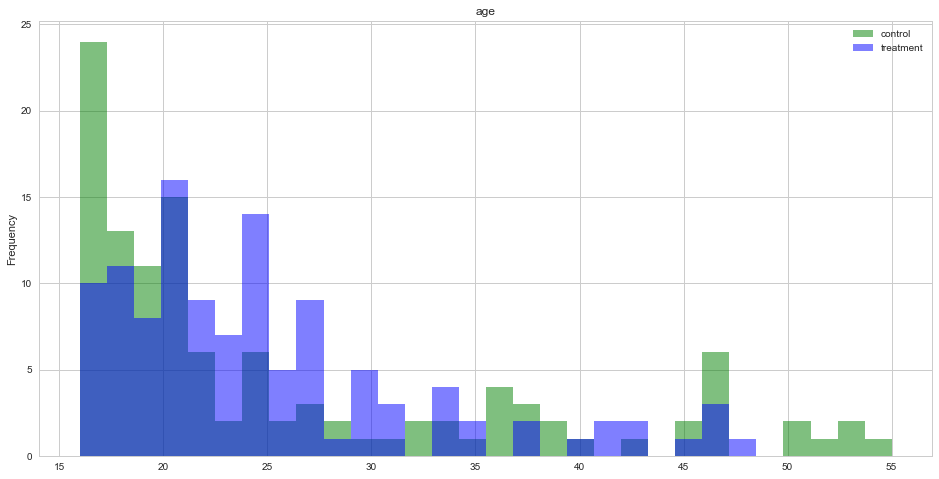

In [58]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'age', {'title' : 'age', 'figsize':(16,8)})

The age distributions are again pretty different in the two groups, but at least the mean of the ages is very similar, around 25 years old, as it can be seen below:

In [59]:
treatment_paired_same_race['age'].mean(), control_paired_same_race['age'].mean()

(25.077586206896552, 25.732758620689655)

Next, we look into the *educ* variable, to check if the distribution changed significantly:

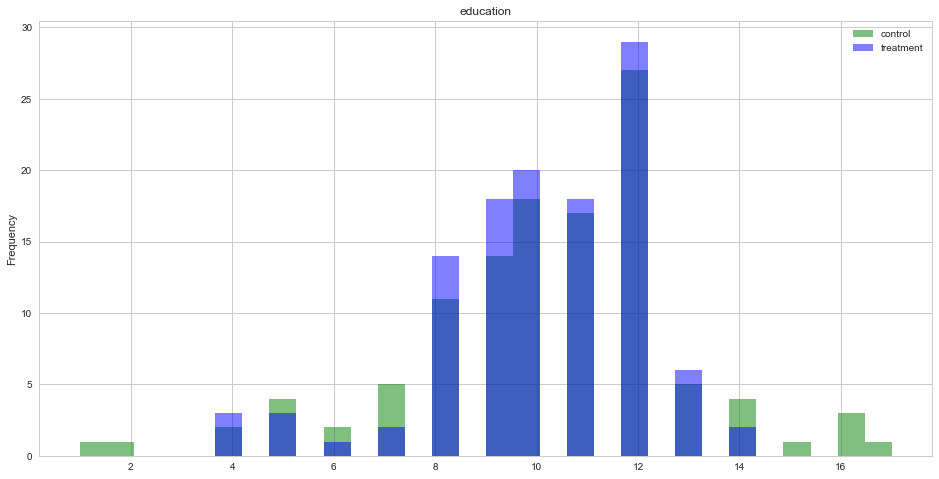

In [60]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'educ', {'title' : 'education', 'figsize':(16,8)})

The *educ* variable seems to keep the similar distribution in treatment and control groups.

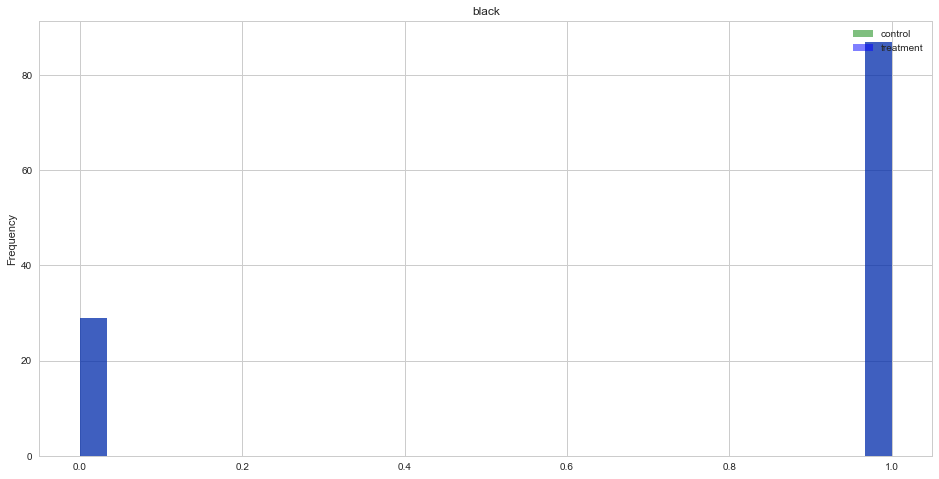

In [61]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'black', {'title' : 'black', 'figsize':(16,8)})

As expected, and validating the correct construction of the algorithm, the *black* variable has **exactly** the same distribution over the two groups, which can be seen in the previous histogram by the fact that we can distinguish one single color, which means that everywhere blue and green overlaps. 

---

Next, we check if the sitribution over the hispanic population changed:

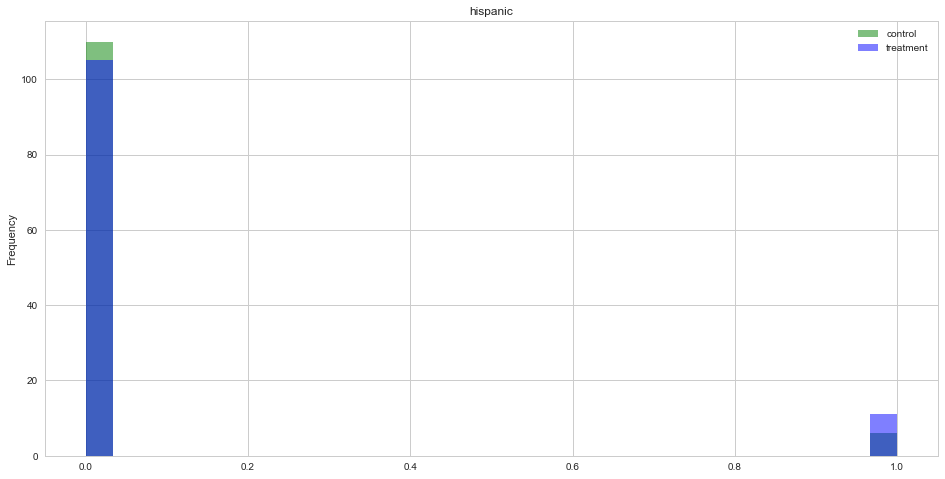

In [62]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'hispan', {'title' : 'hispanic', 'figsize':(16,8)})

The *hispan* feature seems to keep very similar distributions in treatment and control groups. 

--- 

Next, we look into the distribution of *married* feature over the two groups:

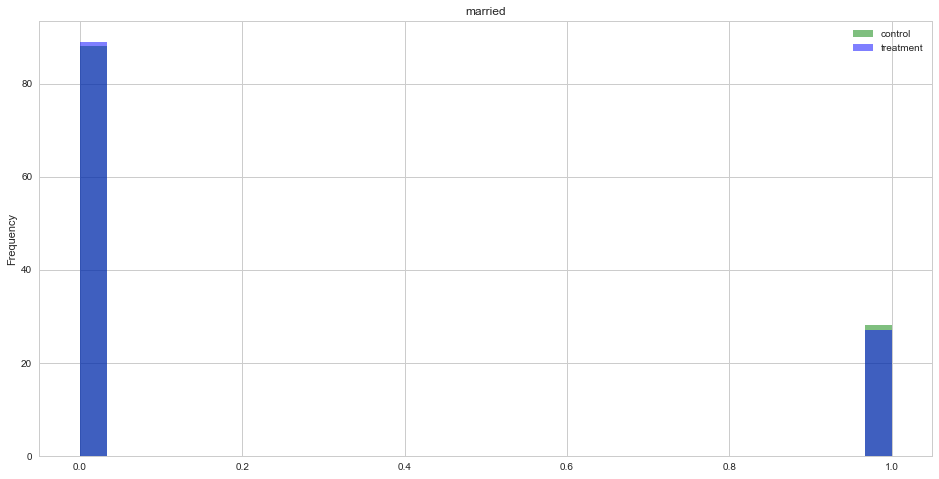

In [63]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'married', {'title' : 'married', 'figsize':(16,8)})

Also, the *married* variable seems to have similar distribution in both groups. 

---

The next variable to analyse is *nodegree*, as performed below:

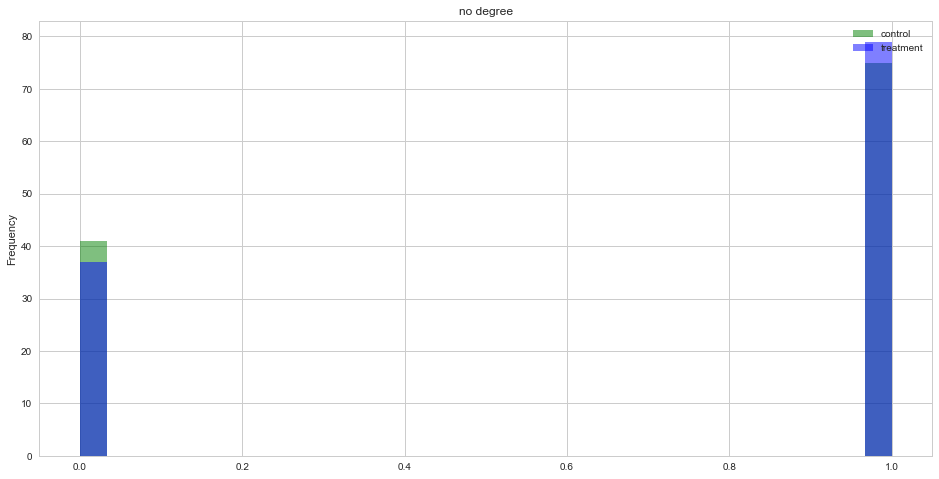

In [64]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 'nodegree', {'title' : 'no degree', 'figsize':(16,8)})

Furthermore, *nodegree* feature distribution over the two groups seems to be similar, and we can say even bettwer than it was before the improvement matching. 

---

From now on, we only have to look into the distribution of earnings before the treatment in the two populations, and it is realized in the next two histograms:

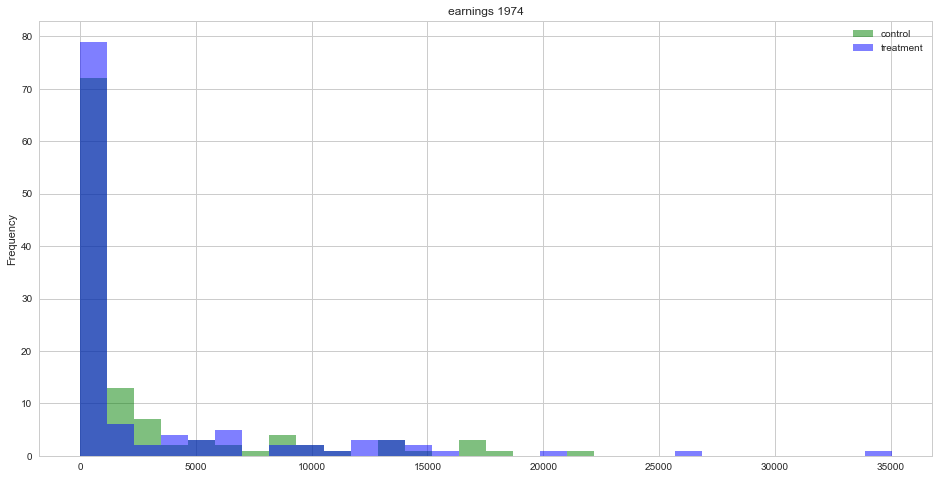

In [65]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 're74', {'title' : 'earnings 1974', 'figsize':(16,8)})

The histogram for earnings in 1974 is barely changed from the one computed over the previous groups. Would it be the same case for the earnings in 1975?

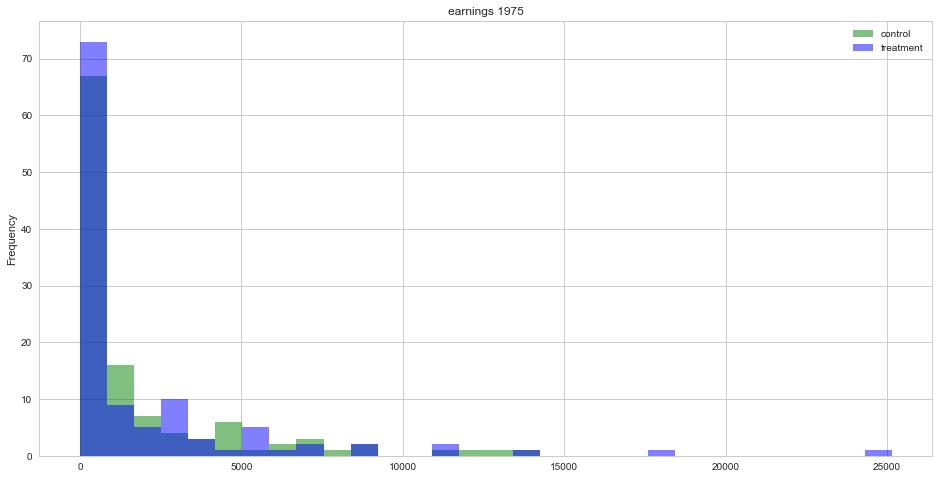

In [66]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 're75', {'title' : 'earnings 1975', 'figsize':(16,8)})

We can say that the difference in histogram is also not noticeable in the latter variable case.

Therefore, we observe that the new groups improved the *black* feature distribution over the treatment and control groups, while keeping the distributions similar for the other features. 

A future improvement would be over the *age* feature, and also arguably on the *re74* and *re75* features. For those features it is consistently harder to balance the distributions, as they take many values and we cannot use the *exact matching* balancing method we used with the *black* variable.

### Task 6 - A less naive approach

<div class="alert alert-block alert-info">
Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?
</div>

We can first look at a straightforward statistic, namely the mean, which will tell us if the earning after applying the treatment increased or not in average, over the balanced groups:

In [67]:
treatment_paired_same_race.re78.mean(), control_paired_same_race.re78.mean()

(6007.1592293103449, 5285.7897004310353)

From the means, we can see that the average income increased with more than 20% on the treatment group, revealing the fact that the training program was in fact a success, despite the results taken from a first look. For a more in-depth comparison, we can plot the histograms of the earnings of the two groups below:

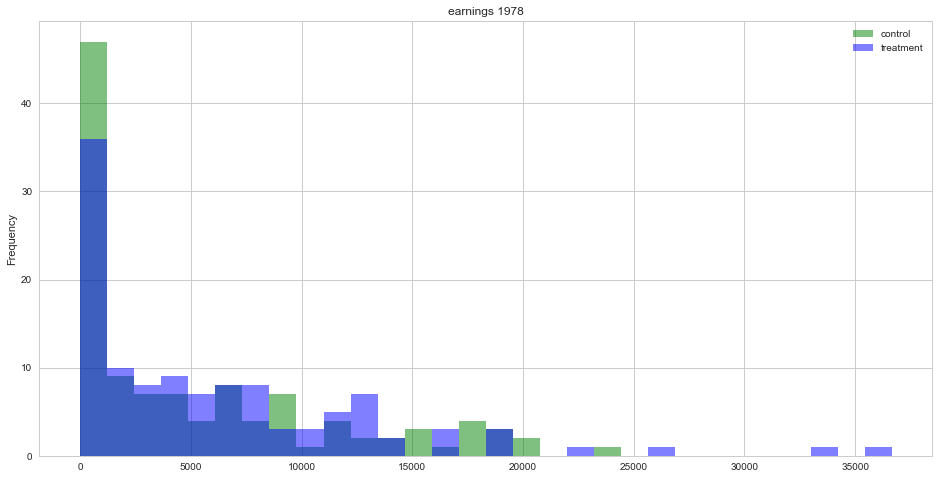

In [68]:
plot_distribution_variable(treatment_paired_same_race, control_paired_same_race, 're78', {'title' : 'earnings 1978', 'figsize':(16, 8)})

From the histogram, we can see that the number of very low incomes decreased in the treatment group, while the number of incomes around \$5000 increased, and also the ones between \$10,000 and \$15,000. In addition, very large salaries appeared, with value almost twice as big as the biggest value in the control group. It would be interesting to look in fact at multiple statistics of the groups, not only the mean, which might be drastically influenced by the outliers and also by the resemblance of the blue histogram with the histogram of a power law, on which the mean or standard deviation are not very useful statistics:

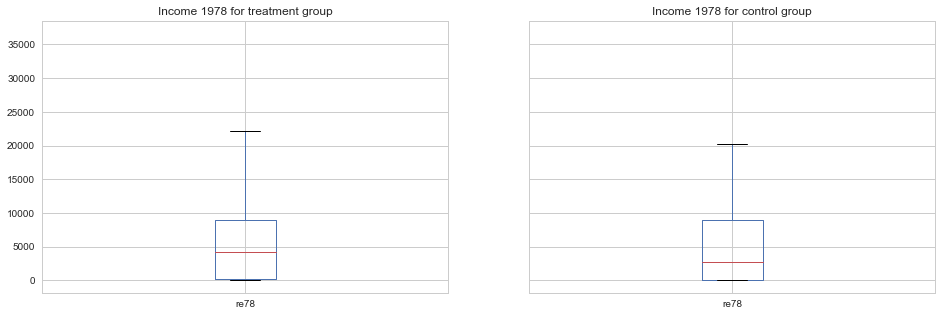

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True);

treatment_paired_same_race.re78.plot.box(ax=axes[0], title='Income 1978 for treatment group')
control_paired_same_race.re78.plot.box(ax=axes[1], title='Income 1978 for control group')

From the previous box plot, we can see that the treatment group has higher general income than the control group, reiterating again the idea that the training program was a success. 

---

The idea to take from the homework is that we should pay attention not only to the high level data that we might collect, but also look into its composition and understand what are the important features. Sometimes, as in this problem's case or in [UC Berkley gender bias case](https://docs.google.com/presentation/d/1sg20BpLzhDdK9UHnqzKt7Kw-44Bb9HBA8ZRMo5Y_sQo/edit#slide=id.g179faf3a1c_0_70), the results that can be seen from the aggregated data can lead to a conclusion which is in contradiction with the reality. Therefore, for extracting the correct conclusion and results, we need to dive deep into the data, create balances between distributions, eventually using propensity score, and then come up with a scientific conclusion, based on facts, and not on merely naive observations.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn [link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

### Tackling plan
1. We use fetch_20newsgroups function from sklearn.datasets to get the data specifying that we want the entire dataset as we will split it for train/test ourselves.
2. We keep only data that is of interest for us (content of the news and labels) and import it in a dataframe.
3. We use TfidfVectorizer to compute TD-IDF features for every article.
4. We train a RandomForestClassifier on the TF-IDF feature vectors. 
5. We use GridSearchCV frunction from sklearn.model_selection in order to fine tune the hyperparameters of our model.
6. We make use of the confusion_matrix function from sklearn.metrics to compute the confusion matrix
7. We have a look at the feature\_importances\_ of our model by plotting the top 20 most important features and also looking at the distribution of the values by studying the quartiles.

### Used libraries

In [70]:
import math
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Preparing the dataset

Firstly we get the dataset by using sklearn functionality. We specify that we want the entire dataset and pass a relative path for the download folder.

In [71]:
data_folder = os.path.join('.','data')
newsgroups_train = fetch_20newsgroups(subset='all', data_home=data_folder)

The obtained data is enclosed in a specific sklearn object, namely Bunch which is basically a dictionary.

In [72]:
newsgroups_train.keys()

dict_keys(['description', 'filenames', 'target', 'data', 'target_names', 'DESCR'])

As we can see it contains multiple entries out of which we are interested in:

* **data** which is a list with the actual content 
* **target** containing the labels for each data entry
* **target_names** containing the textual representation(names) of the labels, useful when we will analyze the output of the classifier

We will create a dataframe with specifically this fields.

In [73]:
df = pd.DataFrame(data={'doc':newsgroups_train['data'], 'label':newsgroups_train['target']})
labels_names = newsgroups_train['target_names']

In order to have a better look at the data, we would like to show it not truncated therefore we remove the max column width limit of pandas display option.

In [74]:
pd.set_option('display.max_colwidth', -1)

In [75]:
df[:3]

,doc,label
0,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",10
1,"From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which high-performance VLB video card?\nSummary: Seek recommendations for VLB video card\nNntp-Posting-Host: midway.ecn.uoknor.edu\nOrganization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA\nKeywords: orchid, stealth, vlb\nLines: 21\n\n My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n\n-- \n | Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu) | \n --+-- ""Now I, Nebuchadnezzar, praise and exalt and glorify the King --+-- \n | of heaven, because everything he does is right and all his ways | \n | are just."" - Nebuchadnezzar, king of Babylon, 562 B.C. | \n",3
2,"From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)\nLines: 95\nNntp-Posting-Host: viktoria.dsv.su.se\nReply-To: hilmi-er@dsv.su.se (Hilmi Eren)\nOrganization: Dept. of Computer and Systems Sciences, Stockholm University\n\n\n\n\n|>The student of ""regional killings"" alias Davidian (not the Davidian religios sect) writes:\n\n\n|>Greater Armenia would stretch from Karabakh, to the Black Sea, to the\n|>Mediterranean, so if you use the term ""Greater Armenia"" use it with care.\n\n\n\tFinally you said what you dream about. Mediterranean???? That was new....\n\tThe area will be ""greater"" after some years, like your ""holocaust"" numbers......\n\n\n\n\n|>It has always been up to the Azeris to end their announced winning of Karabakh \n|>by removing the Armenians! When the president of Azerbaijan, Elchibey, came to \n|>power last year, he announced he would be be ""swimming in Lake Sevan [in \n|>Armeniaxn] by July"".\n\t\t*****\n\tIs't July in USA now????? Here in Sweden it's April and still cold.\n\tOr have you changed your calendar???\n\n\n|>Well, he was wrong! If Elchibey is going to shell the \n|>Armenians of Karabakh from Aghdam, his people will pay the price! If Elchibey \n\t\t\t\t\t\t ****************\n|>is going to shell Karabakh from Fizuli his people will pay the price! If \n\t\t\t\t\t\t ******************\n|>Elchibey thinks he can get away with bombing Armenia from the hills of \n|>Kelbajar, his people will pay the price. \n\t\t\t ***************\n\n\n\tNOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE.\n\t\n\tSHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH\n\t\t\t\t\t\t **************\n\tBEING RAPED, KILLED AND TORTURED BY THE ARMENIANS??????????\n\t\n\tHAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""???????\n\tYOU FACIST!!!!!\n\n\n\n\tOhhh i forgot, this is how Armenians fight, nobody has forgot\n\tyou killings, rapings and torture against the Kurds and Turks once\n\tupon a time!\n \n \n\n|>And anyway, this ""60 \n|>Kurd refugee"" story, as have other stories, are simple fabricat

#### Note
One thing we notice is that the data has a special structure: it containes headers and signature blocks. This will have an impact on the generalization power of our classifier. For a more realistic approach we can remove these blocks and then train a classifier on the data. 

In [76]:
# number of data entries that have a header starting with the source of the email
df.doc.str.startswith('From:').sum()

18038

### Creating the feature vectors

As indicated in the task statement we will use the TfidfVectorizer. This is indeed a good choice for classification as it can successfully filter stop-words by weighting down the frequent terms across the entire corpus.

In [77]:
vectorizer = TfidfVectorizer()
featurized_data = vectorizer.fit_transform(df.doc)

In [78]:
featurized_data.shape

(18846, 173762)

In [79]:
rate = featurized_data.nnz/featurized_data.shape[0]
rate

156.6663482967208

In [80]:
print('We can see that our feature vectors lie in an {}-dimmensional space\
 out of which only an average of {} components are non-zero'.format(featurized_data.shape[1], int(rate)))

We can see that our feature vectors lie in an 173762-dimmensional space out of which only an average of 156 components are non-zero


### Splitting the data into train, validation and test

#### Small note

Because the feature vectors for the documents are very high dimmensional and are stored as a *sparse matrix*, we will not create a dataframe from them because we would have to convert it to a dense matrix which would require quite a lot of memory. Instead, we will keep two different numpy arrays, one for labels and one for data, where the label in row *i* corresponds to the data in row *i*.

In [81]:
X = featurized_data

y = df.label.values

#### Splitting the data

Because we will use the GridSearchCV function to fine-tune our model's hyperparameters, we will split our data only into train and test sets. This is because of how is implemented GridSearchCV, which we will discuss a little later.

For this, we will use the train_test_split function from sklearn which splits the data into random train and test subsets according to the test_size parameter which specifies the fraction of data we want as test. Additionally, we would like to keep the same distribution across the classes in order to not introduce a sampling bias therefore we will use the parameter stratify to specify the class for each data entry upon which the stratified sampling will be done. 

By stratified sampling we understand that instead of just randomly extracting 10% of the data for test, we will look at the labels and for each class we will extract 10% as test data.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=777)

#### Class distribution

We will now have a look at the class distribution across our train and test datasets.

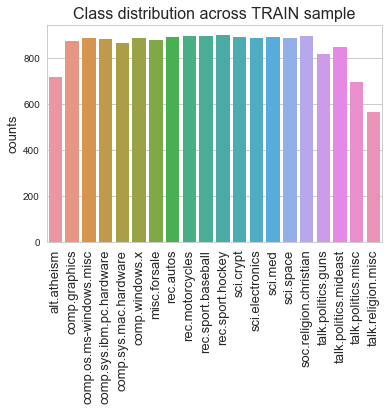

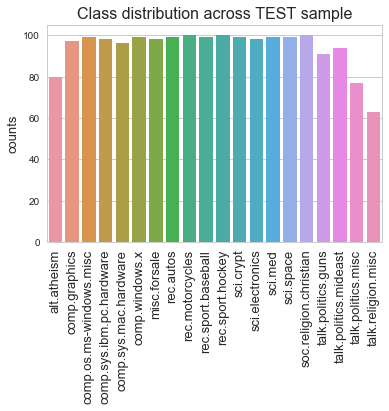

In [83]:
import matplotlib.pyplot as plt
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)


plt.figure()
plt.title('Class distribution across TRAIN sample', fontsize=16)
plt.ylabel('counts', fontsize=13)
g = sns.barplot(x=labels_names, y=train_class_counts)
g.set_xticklabels(labels_names, rotation=90, fontsize=13)
plt.show()

plt.figure()
plt.title('Class distribution across TEST sample', fontsize=16)
plt.ylabel('counts', fontsize=13)
g = sns.barplot(x=labels_names, y=test_class_counts)
g.set_xticklabels(labels_names,rotation=90, fontsize=13)
plt.show()

We can remark that almost all classes are evenly distributed across the data, a more noticeable exception is the talk.religion.misc class which appears to be about a thirds less frequent.

As expected by the train_test_split function, the data's distribution is kept across the two datasets.

### Training and evaluating the model

We will now train a RandomForestClassifier in order to predict the label for the news emails.

In order to fine tune the parameters, we will use cross-validation. Given that the parameters to tune are already chosen, one important decision that is left to be made here is the range of the parameters. For this process we will have an iterative approach in which we will start with some coarse values and after each iteration we will fine-graine our intervals.

>**n_estimators** as discussed in class and from literature we will firstly pick values in the range [10,500]

>**max_depth** will range between [5,40]

Another decision with high importance is the evaluation function to be used when tuning our hyperparameters. Given that the data is reasonably distributed across the classes we will use the simple accuracy metric for evaluation. The accuracy metric returns the fraction of matching labels between the predicted labels and actual labels. In other words, it counts the fraction of data entries we classified correctly.

In order to tune our parameters we will use the sklearn function GridSearchCV.
We pass it a dictionary with parameters values containing an array of values for each parameter and it will iterate over all combinations of these values. It will do, by default, a 3-fold cross-validation to evaluate the current combination.
Given that our estimator is a classifier (RandomForestClassifier) the cross-validation will be a stratified-3-fold cross validation.
Additionally, we will specify the scoring method to be the above mentioned accuracy metric and we will parallelize the training over 4 thread using n_jobs parameter.

One last thing to be mentioned is that GridSearchCV will return the best classifier trained on the entire dataset

In [84]:
rfc = RandomForestClassifier(n_jobs=2, random_state=777)

parameters = {'n_estimators':[10, 50, 100, 200, 300, 400, 500], 'max_depth':[5,10,20,30,40]}

clf = GridSearchCV(rfc, parameters, n_jobs=4, scoring='accuracy', verbose=True)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed: 16.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=777, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [5, 10, 20, 30, 40], 'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [85]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=777, verbose=0, warm_start=False)

In [86]:
clf.grid_scores_

D:\Programs\Anaconda\envs\ada\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.29698, std: 0.00754, params: {'max_depth': 5, 'n_estimators': 10},
 mean: 0.54549, std: 0.01415, params: {'max_depth': 5, 'n_estimators': 50},
 mean: 0.62190, std: 0.00845, params: {'max_depth': 5, 'n_estimators': 100},
 mean: 0.67077, std: 0.00197, params: {'max_depth': 5, 'n_estimators': 200},
 mean: 0.68929, std: 0.00328, params: {'max_depth': 5, 'n_estimators': 300},
 mean: 0.70491, std: 0.00099, params: {'max_depth': 5, 'n_estimators': 400},
 mean: 0.71016, std: 0.00342, params: {'max_depth': 5, 'n_estimators': 500},
 mean: 0.40923, std: 0.01291, params: {'max_depth': 10, 'n_estimators': 10},
 mean: 0.64595, std: 0.00446, params: {'max_depth': 10, 'n_estimators': 50},
 mean: 0.70574, std: 0.00845, params: {'max_depth': 10, 'n_estimators': 100},
 mean: 0.72908, std: 0.00774, params: {'max_depth': 10, 'n_estimators': 200},
 mean: 0.74076, std: 0.00692, params: {'max_depth': 10, 'n_estimators': 300},
 mean: 0.74842, std: 0.00628, params: {'max_depth': 10, 'n_estimators': 400

We can notice from the logs above that the maximum accuracy value was reached at the edge of our parameters values intervals. This is a good indicator that we should explore more values beyond our initial intervals.

In [87]:
rfc = RandomForestClassifier(n_jobs=2, random_state=777)

parameters = {'n_estimators':[400, 500, 600], 'max_depth':[40, 50, 60]}

clf = GridSearchCV(rfc, parameters, n_jobs=4, pre_dispatch=4, scoring='accuracy', verbose=True)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 23.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=777, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [40, 50, 60], 'n_estimators': [400, 500, 600]},
       pre_dispatch=4, refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [88]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=2,
            oob_score=False, random_state=777, verbose=0, warm_start=False)

In [89]:
clf.cv_results_

{'mean_fit_time': array([ 121.56224712,  150.92369175,  174.09004696,  154.99338595,
         192.2858874 ,  230.46741676,  195.7879475 ,  243.52380768,
         259.87623739]),
 'mean_score_time': array([ 4.39944029,  3.08217947,  3.93896349,  2.57682705,  3.3235151 ,
         3.78932556,  2.47818565,  3.43009043,  3.0579373 ]),
 'mean_test_score': array([ 0.8228878 ,  0.82477448,  0.82595366,  0.83078828,  0.83255704,
         0.83467956,  0.83379518,  0.83656624,  0.838335  ]),
 'mean_train_score': array([ 0.98352045,  0.98393339,  0.98490612,  0.99171587,  0.99221704,
         0.99248241,  0.99587262,  0.99584303,  0.99619686]),
 'param_max_depth': masked_array(data = [40 40 40 50 50 50 60 60 60],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [400 500 600 400 500 600 400 500 600],
              mask = [False False False False False False False False False],
        fill_value = ?),
 

Again, the best model has the hyper-parameters at the edge of our searching intervals. Taking into consideration the trade-off between computing time and increasing accuracy, trying to further improve our model would result into smaller accuracy increase but significantly more computing time. Therefore, we will use the best values of the above grid search. 

### Using the model 

We will now take a look at the confusion matrix for the test dataset. In order to do so, we predict the labels for our test dataset and use the sklearn metrics functionalities, namely the confusion_matrix function, along with the real labels to compute the confusion matrix.

Given that the GridSearchCV is a wrapper over the actual estimator, in order to easily analyse feature importances, we will get a reference to the best estimator, i.e. the best RandomForestClassifier.

In [90]:
forest_clf = clf.best_estimator_

In [91]:
y_pred = forest_clf.predict(X_test)

In [92]:
conf_mat = confusion_matrix(y_test, y_pred)

For an easier analysis of the confusion matrix, we will use a clear visual representation of it.

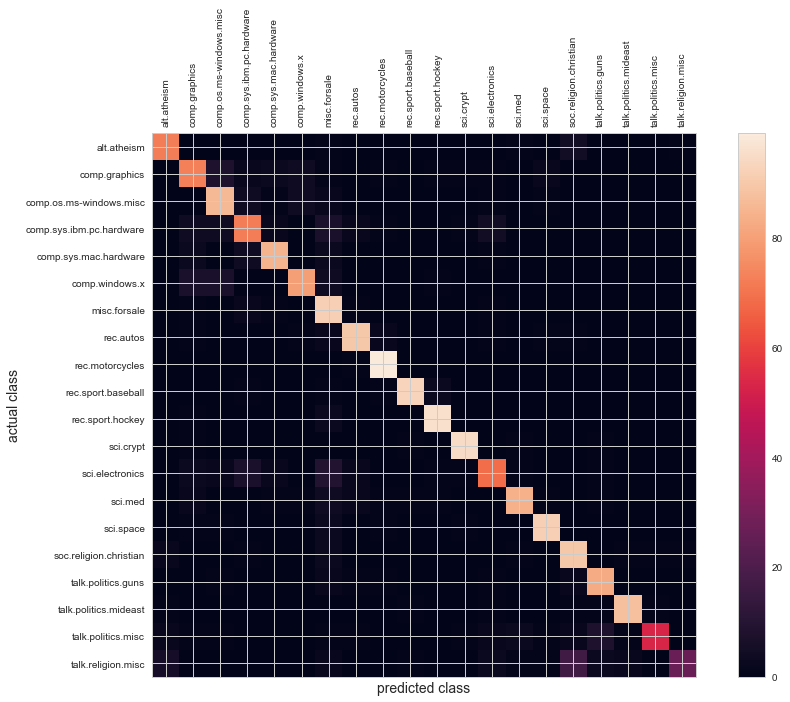

In [93]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
cax = ax.matshow(conf_mat)
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.xaxis.tick_top()

plt.xlabel('predicted class', fontsize=14)
plt.ylabel('actual class', fontsize=14)

plt.xticks(range(20), labels_names, rotation='vertical')
plt.yticks(range(20), labels_names)

plt.show()

To help our analysis, we will also look at the accuracy score of our model.

In [94]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.85888594164456233

We can observe from the confusion matrix that our classifier performs fairly well. Looking at the misclassified data entries, we can see that most of them are examples with related subjects: comp.windows.x and comp.grafics or comp.windows.x and comp.os.ms-windows.misc. Also, the worst classified examples from talk.religion.misc are labeled as soc.religion.christian which is explainable given that having similar subjects, many words are common between the texts but not present in the other classes.

We can therefore state that even if our classifier does a decent job, it still has difficulties with subject-related documents. This might be explainable by the number of different subjects across our corpus. Hence, the IDF part of our vectorizer which penalizes words with high frequency across all documents, will not penalize enough words that have a considerable frequency in subject-related documents.

### Top 20 most important features
We will now have a look at the 20 features with the biggest impact on our classifier

In order to determine the 20 most important features across our entire decision trees forest, we will average the feature importances of each decision tree. This way we create an indicator over the entire model and we will also have a confidence interval. The same approach is used by the library to compute the feature importances for the RandomForestClassifier.

In [100]:
feature_names = np.array(vectorizer.get_feature_names())
top_features = 20 

In [101]:
# we obtain references to our decision trees
decision_trees = forest_clf.estimators_
# we create a matrix where row i containes the feature importances
# corresponding to decision tree i
feature_importances_across_trees = []
for tree in decision_trees:
    feature_importances_across_trees.append(tree.feature_importances_)
    
# we compute the mean and std of the feature importances
# across all the decision trees
mean = np.mean(feature_importances_across_trees, axis=0)
std = np.std(feature_importances_across_trees, axis=0)
sorted_indices = np.argsort(mean)[::-1]

Now that we determined the top most important features, we want to create a dataframe with the importance of the 20 top features across all decision trees in order to see how the values are distributed.

To extract more easily the importances for these features using a list of positions as index, we create a numpy array from the feature importances across the decision trees and then we select only those columns corresponding to the features in top 20 most important.

In [102]:
feat_imp_np = np.array(feature_importances_across_trees)[:,sorted_indices[:top_features]]

After we created the numpy array with the importances of the top 20 features, we use it to obtain the desired dataframe.

In [103]:
df = pd.DataFrame(feat_imp_np)
df.columns = feature_names[sorted_indices[:top_features]]

Now that we have our dataframe created, we can use the describe method to have a better look at the distribution of the feature importances across the decision trees.

In [104]:
df.describe()

,windows,dod,sale,clipper,car,bike,israel,hockey,god,encryption,space,re,team,rutgers,baseball,of,game,athos,cars,the
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.005288,0.005188,0.004980,0.004132,0.003810,0.003761,0.003582,0.003529,0.003309,0.003255,0.003240,0.003016,0.002922,0.002883,0.002711,0.002657,0.002584,0.002554,0.002511,0.002478
std,0.009046,0.010389,0.010767,0.009056,0.007018,0.008153,0.007013,0.006998,0.005920,0.007190,0.006052,0.003926,0.005672,0.006335,0.005213,0.003125,0.005445,0.005864,0.005200,0.002492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000349,0.000000,0.000051,0.000000,0.000140,0.000000,0.000000,0.000000,0.000210,0.000000,0.000087,0.000930,0.000000,0.000000,0.000000,0.001051,0.000000,0.000000,0.000000,0.001135
50%,0.001575,0.000683,0.000690,0.000588,0.000845,0.000399,0.000419,0.000582,0.000889,0.000452,0.000709,0.001585,0.000457,0.000367,0.000576,0.001696,0.000464,0.000072,0.000197,0.001779
75%,0.005237,0.004555,0.002946,0.003138,0.003452,0.002942,0.003540,0.003352,0.003761,0.002790,0.003201,0.003043,0.002606,0.002048,0.002495,0.002808,0.002130,0.001664,0.001940,0.002638
max,0.044330,0.057406,0.058470,0.059699,0.039471,0.044611,0.041434,0.046453,0.037427,0.044768,0.043432,0.019394,0.030083,0.041090,0.030828,0.023886,0.037616,0.037734,0.027423,0.015284


We can remark from the values of the quartiles that the features don't have a big importance across all the decision trees, but rather for a subset of it, aproximatively for 25%. This is explainable because decision trees giving importances to different features helps reducing the overfitting characteristic to a decision tree.

We can also notice that the mean is comparable with the value of the third quantile which sustains the previous remark regarding the big importance for 25% of the decision trees.

What is now left is to plot the 20 most important features with their deviations.

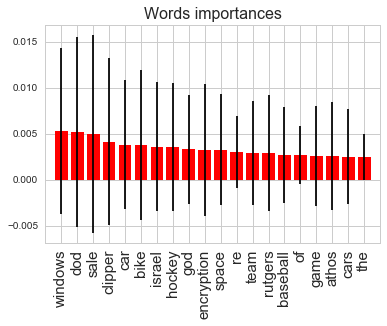

In [105]:
plt.figure()
plt.title("Words importances", fontsize=16)
plt.bar(range(top_features), mean[sorted_indices[:top_features]],
       color="r", yerr=std[sorted_indices[:top_features]], align="center")
plt.xticks(range(top_features), feature_names[sorted_indices[:top_features]], rotation='vertical', fontsize=15)
plt.xlim([-1, top_features])
plt.show()

In [107]:
labels_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

First thing we notice is the **high variance** in the importance of the features. This is explained by the big number of decision trees in our classifier (600). 

If we try to analyze the feature importances looking at the words they correspond to, we notice that the classifier is able to identify some topics/key-words in the documents and diferentiate them based on these topics. For example **windows**, which has the biggest averaged importance, is strongly related to the comp.\* class of subjects. Another example that our classifier manages to select proper keywords from the docs is the high importance our classifier give to the word **god** as it is reasonably to assume that this words is more specific to subjects **alt.atheism** or **soc.religion.christian** than, say, **comp.graphics** which makes it a good feature to differentiate upon.